In [93]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.ensemble import MajorityVotingClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.ensemble import RakelO
from skmultilearn.model_selection import IterativeStratification
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit
from mlxtend.evaluate.time_series import plot_splits
from mlxtend.evaluate.time_series import print_cv_info
from mlxtend.evaluate.time_series import print_split_info
import optuna
from functools import partial
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import seaborn as sns
import pickle
import warnings
from collected_functions import *


Set base variable values

In [94]:
random_state = 42
np.random.seed(random_state)
cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': random_state}


Adjust Pandas settings to display more information before truncation.

In [95]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

Load combined MA and DDS training data

In [96]:
df = pd.read_parquet('combined_training_set_nontime.parquet')
print(df.shape)
df.head()

(6765, 22)


,incidentId,state,incidentTypeMA,region,maType,maPriority,supportFunction,agencyId,maId,declarationType,assistanceRequested,statementOfWork,femaDeclarationString,incidentType,incidentBeginDate,fipsStateCode,designatedIncidentTypes,declarationTitle,year,month,day,AR_topic
0,2024081901,CT,Severe Storm,1,FOS,High,5.0,DOI-USGS,3612EMCTDOI-USGS01,EM,USGS Field measurements of flood-water heights...,"As directed by and in coordination with FEMA, ...",EM-3612-CT,Severe Storm,2024-08-18 00:00:00+00:00,9.0,"Severe Storm,Flood,Mud/Landslide","SEVERE STORMS, FLOODING, LANDSLIDES, AND MUDSL...",2024.0,8.0,18.0,28
1,2024072801,FL,Tropical Storm,4,FOS,Normal,8.0,VA,4806DRFLVA02,DR,Activate VHA OEM to NRCC ESF-8 PHMS. This is a...,As directed by and in coordination with FEMA a...,DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,23
2,2024072801,FL,Tropical Storm,4,FOS,Normal,0.0,VA,4806DRFLVA01,DR,Activate VA to NRCC. This is a re-issuance of ...,"As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,23
3,2024072801,FL,Tropical Storm,4,FOS,Normal,4.0,USDA-FS,4806DRFLUSDA-FS01,DR,Activate USFS to the NRCC. This is a re-issuan...,"As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,30
4,2024072801,FL,Tropical Storm,4,FOS,Normal,11.0,USDA-APH,4806DRFLUSDA-APH01,DR,"USDA liaison(s) to the NRCC, FEMA teams, or ot...","As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,32


Transform the training data set using approach that is suitable for multiple categorical feature columns and a multilabel target. We return the transformers so that the test data set can be transformed later.

In [97]:
feature_columns = [
    'incidentId',
    'state',
    'designatedIncidentTypes',
    'declarationType',
    'region',
    'year',
]

target_column = 'supportFunction'

X_train, y_train = create_set(df, feature_columns, target_column)

print(X_train.shape, len(y_train))
print(y_train[:5])
X_train.head(5)

(464, 6) 464
0                         [7.0]
1                         [7.0]
2                         [7.0]
3    [2.0, 3.0, 7.0, 9.0, 13.0]
4        [8.0, 1.0, 10.0, 13.0]
Name: supportFunction, dtype: object


,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2013020801,CT,Severe Storm,DR,1,2013.0
1,2013020801,NH,Severe Storm,DR,1,2013.0
2,2013020801,RI,Severe Storm,DR,1,2013.0
3,2013041203,ND,Flood,EM,8,2013.0
4,2013041501,MA,Terrorist,EM,1,2013.0


In [98]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_train['designatedIncidentTypes'] = X_train['designatedIncidentTypes'].str.split(',')


In [99]:
# Since designatedIncidentTypes is a list it must be transformed differently than the other
# feature columns.
feature_columns_transform = [
    'state',
    'declarationType',
    'region',
]

X_train_transformed, y_train_transformed, preprocessor_X, preprocessor_y = transform_x_y_train(
    X_train,
    y_train,
    feature_columns_transform,
    ['designatedIncidentTypes'],
    target_column,
    'ESF_'
)

In [100]:
# Assign the year values to a variable, then drop year and incidentId from X_train_transformed.
groups_by_year = X_train_transformed['year'].values
X_train_transformed.drop(columns=['incidentId', 'year'], inplace=True)
print(X_train_transformed.shape)
X_train_transformed.head()

(464, 89)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,declarationType_DR,declarationType_EM,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,designatedIncidentTypes_Biological,designatedIncidentTypes_Chemical,designatedIncidentTypes_Coastal Storm,designatedIncidentTypes_Dam/Levee Break,designatedIncidentTypes_Earthquake,designatedIncidentTypes_Fire,designatedIncidentTypes_Flood,designatedIncidentTypes_Hurricane,designatedIncidentTypes_Mud/Landslide,designatedIncidentTypes_Other,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Depression,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
print(y_train_transformed.shape)
y_train_transformed.head()

(464, 16)


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0


Run a variety of machine learning models and base classifiers using cross validation for model selection purposes.

In [102]:
# Create base classifiers for use with other models.
base_svc = SVC(
    gamma='auto',
    decision_function_shape='ovo',
    class_weight='balanced',
    random_state=random_state,
)
base_xgb = XGBClassifier(
    max_depth=12,
    random_state=random_state,
    n_estimators=100,
    base_score=0.5,
)
base_gnb = GaussianNB()

# Use some models from skmultilearn
br_classifier_svc = BinaryRelevance(
    classifier = base_svc,
    require_dense = [True, True]
)
br_classifier_xgb = BinaryRelevance(
    classifier = base_xgb,
    require_dense = [True, True]
)
br_classifier_gnb = BinaryRelevance(
    classifier = base_gnb,
    require_dense = [True, True]
)

cc_classifier_svc = ClassifierChain(
    classifier=base_svc, 
    require_dense=[True, True],
    order = list(range(0,16)),
)
cc_classifier_xgb = ClassifierChain(
    classifier=base_xgb,
    require_dense=[True, True],
    order = list(range(0,16)),
)
cc_classifier_gnb = ClassifierChain(
    classifier=base_gnb,
    require_dense=[True, True],
    order = list(range(0,16)),
)
cc_classifier_lr = ClassifierChain(
    classifier=LogisticRegression(max_iter=300),
    require_dense=[True, True],
)

# Check performance of sklearn models that can natively handle multiclass targets.
base_rf = RandomForestClassifier(
    random_state=random_state,
    n_jobs=-1,
    max_depth=12,
    n_estimators=100,
    class_weight='balanced_subsample'
)

base_etc = ExtraTreesClassifier(
    random_state=random_state,
    max_depth=12,
    n_jobs=-1,
    class_weight='balanced_subsample',
)

# Finish with sklearn models that require a base estimator.
moc_svc = MultiOutputClassifier(estimator=base_svc)
moc_xgb = MultiOutputClassifier(estimator=base_xgb)
moc_gnb = MultiOutputClassifier(estimator=base_gnb)

ovr_svc = OneVsRestClassifier(estimator=base_svc)
ovr_xgb = OneVsRestClassifier(estimator=base_xgb)
ovr_gnb = OneVsRestClassifier(estimator=base_gnb)

clf_list = [
    br_classifier_svc,
    br_classifier_xgb,
    br_classifier_gnb,
    cc_classifier_svc,
    cc_classifier_xgb,
    cc_classifier_gnb,
    cc_classifier_lr,
    base_rf,
    base_etc,
    moc_svc,
    moc_xgb,
    moc_gnb,
    ovr_svc,
    ovr_xgb,
    ovr_gnb,
]

# Set up some scoring options that work well with multiclass results.
hamming_scorer = make_scorer(
    hamming_loss,
    greater_is_better=False, 
)

F1_Macro_Avg = make_scorer(
    f1_score,
    average='macro', 
    zero_division=1,
)

F1_Samples_Avg = make_scorer(
    f1_score,
    average='samples', 
    zero_division=1,
)

# include mAP with the understanding that some of our models output sparse arrays which
# does not work in our scoring setup using cross_validate.
mean_average_precision = make_scorer(
    average_precision_score,
    average='macro', 
)

scoring = {
    'Hamming':hamming_scorer,
    'F1_Macro_Avg':F1_Macro_Avg,
    'F1_Samples_Avg':F1_Samples_Avg,
    'mAP':mean_average_precision,
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming Loss: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Mean Average Precision: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')

BinaryRelevance(classifier=SVC(class_weight='balanced',
                               decision_function_shape='ovo', gamma='auto',
                               random_state=42),
                require_dense=[True, True])
Mean Hamming Loss: -0.2927244039270687, 0.04516876466261546

Mean F1 Macro Avg: 0.4559641247526722, 0.07679530611256528

Mean F1 Samples Avg: 0.5045256741299241, 0.0304706666423988

Mean Mean Average Precision: nan, nan
BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         featur

XGBoost appears to be our best base model based on Hamming Loss and F1 scores, though SVC does beat it on F1 scores alone. The most promising models appear to be BinaryRelevance, ClassifierChain, and OneVsRestClassifier (MultiOutputClassification had similar results and OneVsRestClassifier is more suited to this sort of task per documentation).

We can start with hyperparameter tuning of BinaryRelevance and the XGBoost base classifier. We will be using Optuna for all models to keep outcomes consistent.

In [103]:
def objective_brxgb(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    base_XGB = XGBClassifier(**xgb_params)
    
    clf = BinaryRelevance(
        classifier = base_XGB,
        require_dense = [True, True],
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        eval_scorer = combined_score(y_val, y_pred.toarray())

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())
        scores.append(eval_scorer)

    return np.mean(scores)

cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': random_state}

objective_brxgb = partial(objective_brxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state=random_state,
                        )

# Maximize the score to improve results
study_brxgb = optuna.create_study(direction="maximize")

study_brxgb.optimize(objective_brxgb, n_trials=60, show_progress_bar=True)

print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_brxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_brxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-26 15:44:21,020] A new study created in memory with name: no-name-0808d1c0-5c70-4b46-850c-da91c38ba4d5
Best trial: 0. Best value: 1.24264:   2%|▏         | 1/60 [00:07<07:48,  7.94s/it]

[I 2025-11-26 15:44:29,052] Trial 0 finished with value: 1.2426419726584825 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.0469042882825398, 'subsample': 0.7186912356504366, 'colsample_bytree': 0.714785184192718, 'scale_pos_weight': 2.1155299750834304}. Best is trial 0 with value: 1.2426419726584825.


Best trial: 0. Best value: 1.24264:   3%|▎         | 2/60 [00:31<16:32, 17.12s/it]

[I 2025-11-26 15:44:52,593] Trial 1 finished with value: 1.2184445523902967 and parameters: {'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.02102704347262674, 'subsample': 0.9196854878176852, 'colsample_bytree': 0.6153276849937703, 'scale_pos_weight': 3.6138052307921464}. Best is trial 0 with value: 1.2426419726584825.


Best trial: 0. Best value: 1.24264:   5%|▌         | 3/60 [00:49<16:35, 17.46s/it]

[I 2025-11-26 15:45:10,466] Trial 2 finished with value: 1.2351477272853177 and parameters: {'n_estimators': 250, 'max_depth': 14, 'learning_rate': 0.00018617735991256472, 'subsample': 0.7496888865999338, 'colsample_bytree': 0.8856009333198416, 'scale_pos_weight': 3.7648203631925528}. Best is trial 0 with value: 1.2426419726584825.


Best trial: 0. Best value: 1.24264:   7%|▋         | 4/60 [00:58<13:10, 14.12s/it]

[I 2025-11-26 15:45:19,464] Trial 3 finished with value: 1.1341673777958685 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0006068188518548667, 'subsample': 0.7138230118559934, 'colsample_bytree': 0.8998295318659679, 'scale_pos_weight': 5.851076501468854}. Best is trial 0 with value: 1.2426419726584825.


Best trial: 0. Best value: 1.24264:   8%|▊         | 5/60 [01:08<11:36, 12.66s/it]

[I 2025-11-26 15:45:29,533] Trial 4 finished with value: 1.1983975709997916 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.0008449137455441988, 'subsample': 0.8172595565524639, 'colsample_bytree': 0.740224441198664, 'scale_pos_weight': 3.260695966110702}. Best is trial 0 with value: 1.2426419726584825.


Best trial: 0. Best value: 1.24264:  10%|█         | 6/60 [01:11<08:25,  9.37s/it]

[I 2025-11-26 15:45:32,506] Trial 5 finished with value: 1.229483049029611 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.0045162663508623345, 'subsample': 0.790641949985811, 'colsample_bytree': 0.7162644331335539, 'scale_pos_weight': 3.3107092742428947}. Best is trial 0 with value: 1.2426419726584825.


Best trial: 6. Best value: 1.24912:  12%|█▏        | 7/60 [01:14<06:25,  7.27s/it]

[I 2025-11-26 15:45:35,467] Trial 6 finished with value: 1.2491234094879544 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.07796863994558761, 'subsample': 0.6011669977685178, 'colsample_bytree': 0.8837728735671635, 'scale_pos_weight': 4.236674313308046}. Best is trial 6 with value: 1.2491234094879544.


Best trial: 6. Best value: 1.24912:  13%|█▎        | 8/60 [01:28<08:09,  9.42s/it]

[I 2025-11-26 15:45:49,476] Trial 7 finished with value: 1.2120820905729075 and parameters: {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.09058840078265408, 'subsample': 0.8913725113889369, 'colsample_bytree': 0.7344417619630894, 'scale_pos_weight': 4.778715013414701}. Best is trial 6 with value: 1.2491234094879544.


Best trial: 6. Best value: 1.24912:  15%|█▌        | 9/60 [01:41<09:06, 10.72s/it]

[I 2025-11-26 15:46:03,075] Trial 8 finished with value: 1.2485552595417146 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.0011524375339129903, 'subsample': 0.8638057492943554, 'colsample_bytree': 0.6525886007754542, 'scale_pos_weight': 4.595669603040785}. Best is trial 6 with value: 1.2491234094879544.


Best trial: 6. Best value: 1.24912:  17%|█▋        | 10/60 [01:53<09:11, 11.03s/it]

[I 2025-11-26 15:46:14,785] Trial 9 finished with value: 1.2456838685960896 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.0010390666195372184, 'subsample': 0.9202474875576483, 'colsample_bytree': 0.6089256540538961, 'scale_pos_weight': 2.793682198586652}. Best is trial 6 with value: 1.2491234094879544.


Best trial: 10. Best value: 1.25002:  18%|█▊        | 11/60 [01:57<07:13,  8.85s/it]

[I 2025-11-26 15:46:18,696] Trial 10 finished with value: 1.2500223208742942 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.00819516091091726, 'subsample': 0.6198722780242185, 'colsample_bytree': 0.8094078008991583, 'scale_pos_weight': 2.4415177633157605}. Best is trial 10 with value: 1.2500223208742942.


Best trial: 10. Best value: 1.25002:  20%|██        | 12/60 [02:00<05:44,  7.19s/it]

[I 2025-11-26 15:46:22,074] Trial 11 finished with value: 1.2400970760938914 and parameters: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.010947966041504697, 'subsample': 0.6033169455744447, 'colsample_bytree': 0.8250348741107095, 'scale_pos_weight': 2.040295419902327}. Best is trial 10 with value: 1.2500223208742942.


Best trial: 10. Best value: 1.25002:  22%|██▏       | 13/60 [02:06<05:15,  6.72s/it]

[I 2025-11-26 15:46:27,715] Trial 12 finished with value: 1.2494471627619614 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.007613560049274118, 'subsample': 0.6002392626448984, 'colsample_bytree': 0.8294665539697926, 'scale_pos_weight': 2.6195177993981593}. Best is trial 10 with value: 1.2500223208742942.


Best trial: 10. Best value: 1.25002:  23%|██▎       | 14/60 [02:13<05:17,  6.91s/it]

[I 2025-11-26 15:46:35,071] Trial 13 finished with value: 1.2492557332659147 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.004521464675580124, 'subsample': 0.6568215705486083, 'colsample_bytree': 0.8152026003025197, 'scale_pos_weight': 2.5287327627461513}. Best is trial 10 with value: 1.2500223208742942.


Best trial: 10. Best value: 1.25002:  25%|██▌       | 15/60 [02:19<04:59,  6.65s/it]

[I 2025-11-26 15:46:41,102] Trial 14 finished with value: 1.246298740379187 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.012887768076652683, 'subsample': 0.6614772076115181, 'colsample_bytree': 0.948632027984375, 'scale_pos_weight': 2.5431133286678005}. Best is trial 10 with value: 1.2500223208742942.


Best trial: 10. Best value: 1.25002:  27%|██▋       | 16/60 [02:27<05:02,  6.88s/it]

[I 2025-11-26 15:46:48,528] Trial 15 finished with value: 1.239890792238889 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.0028348878487523474, 'subsample': 0.6476171513707353, 'colsample_bytree': 0.8003129783690243, 'scale_pos_weight': 2.843355399460834}. Best is trial 10 with value: 1.2500223208742942.


Best trial: 10. Best value: 1.25002:  28%|██▊       | 17/60 [02:33<04:48,  6.70s/it]

[I 2025-11-26 15:46:54,816] Trial 16 finished with value: 1.248773716436146 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.02810320606665913, 'subsample': 0.7062853326904646, 'colsample_bytree': 0.7783505125740634, 'scale_pos_weight': 2.3066699207378396}. Best is trial 10 with value: 1.2500223208742942.


Best trial: 17. Best value: 1.25234:  30%|███       | 18/60 [02:43<05:18,  7.59s/it]

[I 2025-11-26 15:47:04,467] Trial 17 finished with value: 1.2523416331913535 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.002657189635896457, 'subsample': 0.6309861242893444, 'colsample_bytree': 0.8462108292454609, 'scale_pos_weight': 2.892703444959895}. Best is trial 17 with value: 1.2523416331913535.


Best trial: 17. Best value: 1.25234:  32%|███▏      | 19/60 [02:55<06:08,  8.99s/it]

[I 2025-11-26 15:47:16,711] Trial 18 finished with value: 1.248086485394028 and parameters: {'n_estimators': 175, 'max_depth': 13, 'learning_rate': 0.002511707749383675, 'subsample': 0.6774767924932537, 'colsample_bytree': 0.8563904290808277, 'scale_pos_weight': 3.0700259862776096}. Best is trial 17 with value: 1.2523416331913535.


Best trial: 17. Best value: 1.25234:  33%|███▎      | 20/60 [03:04<06:02,  9.07s/it]

[I 2025-11-26 15:47:25,965] Trial 19 finished with value: 1.233651575968901 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.00020136129750075558, 'subsample': 0.6313219427952037, 'colsample_bytree': 0.9431595466058995, 'scale_pos_weight': 2.2911109954308113}. Best is trial 17 with value: 1.2523416331913535.


Best trial: 17. Best value: 1.25234:  35%|███▌      | 21/60 [03:16<06:23,  9.82s/it]

[I 2025-11-26 15:47:37,549] Trial 20 finished with value: 1.243918006448661 and parameters: {'n_estimators': 175, 'max_depth': 12, 'learning_rate': 0.00041598539171636107, 'subsample': 0.752556058801939, 'colsample_bytree': 0.7615720093201916, 'scale_pos_weight': 2.927083497012023}. Best is trial 17 with value: 1.2523416331913535.


Best trial: 17. Best value: 1.25234:  37%|███▋      | 22/60 [03:21<05:15,  8.30s/it]

[I 2025-11-26 15:47:42,286] Trial 21 finished with value: 1.2409889538614212 and parameters: {'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.007707000721948835, 'subsample': 0.6242919005432759, 'colsample_bytree': 0.8403574776640714, 'scale_pos_weight': 2.574198465136707}. Best is trial 17 with value: 1.2523416331913535.


Best trial: 17. Best value: 1.25234:  38%|███▊      | 23/60 [03:25<04:27,  7.24s/it]

[I 2025-11-26 15:47:47,058] Trial 22 finished with value: 1.2417805815580436 and parameters: {'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.0017672390541253991, 'subsample': 0.6833210510420313, 'colsample_bytree': 0.860828911817123, 'scale_pos_weight': 2.322852933289452}. Best is trial 17 with value: 1.2523416331913535.


Best trial: 17. Best value: 1.25234:  40%|████      | 24/60 [03:34<04:33,  7.59s/it]

[I 2025-11-26 15:47:55,470] Trial 23 finished with value: 1.2447903821060275 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.0063272002017214345, 'subsample': 0.6254321366661304, 'colsample_bytree': 0.796413411448621, 'scale_pos_weight': 2.6412068352568303}. Best is trial 17 with value: 1.2523416331913535.


Best trial: 24. Best value: 1.25463:  42%|████▏     | 25/60 [03:38<03:49,  6.55s/it]

[I 2025-11-26 15:47:59,579] Trial 24 finished with value: 1.2546256456025169 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.018107700059508944, 'subsample': 0.6022032609343484, 'colsample_bytree': 0.9133220454017157, 'scale_pos_weight': 3.121789382868149}. Best is trial 24 with value: 1.2546256456025169.


Best trial: 25. Best value: 1.27344:  43%|████▎     | 26/60 [03:42<03:18,  5.84s/it]

[I 2025-11-26 15:48:03,774] Trial 25 finished with value: 1.2734369140844044 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.027001437838359763, 'subsample': 0.6819857445443749, 'colsample_bytree': 0.9212859508109471, 'scale_pos_weight': 3.246970688522156}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  45%|████▌     | 27/60 [03:50<03:30,  6.38s/it]

[I 2025-11-26 15:48:11,415] Trial 26 finished with value: 1.2619426931841446 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.02218411051561197, 'subsample': 0.6953392719883031, 'colsample_bytree': 0.918390987704851, 'scale_pos_weight': 3.587404143594788}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  47%|████▋     | 28/60 [03:54<03:01,  5.67s/it]

[I 2025-11-26 15:48:15,412] Trial 27 finished with value: 1.2580197192432174 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.023160774916891464, 'subsample': 0.6917276433813715, 'colsample_bytree': 0.9191350458101593, 'scale_pos_weight': 3.9285679175367694}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  48%|████▊     | 29/60 [04:01<03:08,  6.07s/it]

[I 2025-11-26 15:48:22,419] Trial 28 finished with value: 1.2587144529761836 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.040097884286643924, 'subsample': 0.7433380713709334, 'colsample_bytree': 0.9228536848454305, 'scale_pos_weight': 3.9481556588668023}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  50%|█████     | 30/60 [04:07<03:03,  6.13s/it]

[I 2025-11-26 15:48:28,679] Trial 29 finished with value: 1.2553982437506996 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.0445533379881399, 'subsample': 0.7491749175029617, 'colsample_bytree': 0.9298618258028589, 'scale_pos_weight': 4.083198137944109}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  52%|█████▏    | 31/60 [04:15<03:13,  6.67s/it]

[I 2025-11-26 15:48:36,633] Trial 30 finished with value: 1.2455962633454152 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.056707628049861, 'subsample': 0.7304049957120513, 'colsample_bytree': 0.8789997396741127, 'scale_pos_weight': 5.239884962068659}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  53%|█████▎    | 32/60 [04:22<03:09,  6.76s/it]

[I 2025-11-26 15:48:43,576] Trial 31 finished with value: 1.2647554044858609 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.03192148582286686, 'subsample': 0.6971740948983555, 'colsample_bytree': 0.919021538886729, 'scale_pos_weight': 3.8678277653918496}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  55%|█████▌    | 33/60 [04:29<03:04,  6.82s/it]

[I 2025-11-26 15:48:50,533] Trial 32 finished with value: 1.2627686876981854 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.03373856067916538, 'subsample': 0.7739723689363507, 'colsample_bytree': 0.9095489509971411, 'scale_pos_weight': 3.547972175895593}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  57%|█████▋    | 34/60 [04:35<02:54,  6.73s/it]

[I 2025-11-26 15:48:57,064] Trial 33 finished with value: 1.2610429612423444 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.03529413327029793, 'subsample': 0.7869828667124217, 'colsample_bytree': 0.9072811484260734, 'scale_pos_weight': 3.5390340511208245}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  58%|█████▊    | 35/60 [04:44<03:01,  7.25s/it]

[I 2025-11-26 15:49:05,544] Trial 34 finished with value: 1.2687535900154387 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.017930924741090957, 'subsample': 0.8214135023499997, 'colsample_bytree': 0.8742958112004214, 'scale_pos_weight': 3.620518287162579}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  60%|██████    | 36/60 [04:51<02:51,  7.14s/it]

[I 2025-11-26 15:49:12,402] Trial 35 finished with value: 1.2176117607113655 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.014822358874440118, 'subsample': 0.8178162697363309, 'colsample_bytree': 0.8823422101181609, 'scale_pos_weight': 4.439061674168707}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  62%|██████▏   | 37/60 [05:02<03:12,  8.35s/it]

[I 2025-11-26 15:49:23,582] Trial 36 finished with value: 1.20400942140189 and parameters: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.06039999612322533, 'subsample': 0.8362847757910278, 'colsample_bytree': 0.8927665227192899, 'scale_pos_weight': 3.372026332105627}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  63%|██████▎   | 38/60 [05:13<03:18,  9.02s/it]

[I 2025-11-26 15:49:34,153] Trial 37 finished with value: 1.2646600951294615 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.03089984754918582, 'subsample': 0.9477093773201426, 'colsample_bytree': 0.8679033012221828, 'scale_pos_weight': 3.7265539304944943}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  65%|██████▌   | 39/60 [05:22<03:11,  9.13s/it]

[I 2025-11-26 15:49:43,535] Trial 38 finished with value: 1.2285592002967491 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.06878981476372582, 'subsample': 0.9471271505838609, 'colsample_bytree': 0.8591705557112866, 'scale_pos_weight': 3.794411101623418}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  67%|██████▋   | 40/60 [05:31<03:02,  9.15s/it]

[I 2025-11-26 15:49:52,729] Trial 39 finished with value: 1.2167936863220885 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.01767445121873688, 'subsample': 0.8623758622488722, 'colsample_bytree': 0.6560567057021341, 'scale_pos_weight': 4.926400260367574}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  68%|██████▊   | 41/60 [05:40<02:53,  9.16s/it]

[I 2025-11-26 15:50:01,913] Trial 40 finished with value: 1.209757964508288 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.09466717452229259, 'subsample': 0.8896917365365048, 'colsample_bytree': 0.8726315106743099, 'scale_pos_weight': 4.250349193265635}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  70%|███████   | 42/60 [05:50<02:45,  9.20s/it]

[I 2025-11-26 15:50:11,206] Trial 41 finished with value: 1.2456837961477292 and parameters: {'n_estimators': 225, 'max_depth': 6, 'learning_rate': 0.030697578998664175, 'subsample': 0.78145986286811, 'colsample_bytree': 0.8961653937097569, 'scale_pos_weight': 3.4363757202812986}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  72%|███████▏  | 43/60 [06:01<02:45,  9.73s/it]

[I 2025-11-26 15:50:22,168] Trial 42 finished with value: 1.2604260917055228 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.031105680870703593, 'subsample': 0.7682844972183428, 'colsample_bytree': 0.932929729036976, 'scale_pos_weight': 3.7362409912624743}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  73%|███████▎  | 44/60 [06:13<02:48, 10.51s/it]

[I 2025-11-26 15:50:34,512] Trial 43 finished with value: 1.2146047084098885 and parameters: {'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.044622901591699904, 'subsample': 0.8078477315268787, 'colsample_bytree': 0.9001670582308255, 'scale_pos_weight': 3.1658903491144144}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  75%|███████▌  | 45/60 [06:20<02:21,  9.41s/it]

[I 2025-11-26 15:50:41,359] Trial 44 finished with value: 1.252099735447381 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.013425456952476822, 'subsample': 0.7120296465398012, 'colsample_bytree': 0.8696422931124562, 'scale_pos_weight': 3.711002090414569}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  77%|███████▋  | 46/60 [06:25<01:53,  8.07s/it]

[I 2025-11-26 15:50:46,306] Trial 45 finished with value: 1.2441826285108406 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.010810139609493735, 'subsample': 0.8460161193665264, 'colsample_bytree': 0.9401482913263038, 'scale_pos_weight': 3.2586533636441795}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  78%|███████▊  | 47/60 [06:34<01:49,  8.46s/it]

[I 2025-11-26 15:50:55,662] Trial 46 finished with value: 1.2568146532853688 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.023588403918601737, 'subsample': 0.931216340864932, 'colsample_bytree': 0.9005054298404385, 'scale_pos_weight': 4.232062559313266}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  80%|████████  | 48/60 [06:39<01:28,  7.34s/it]

[I 2025-11-26 15:51:00,388] Trial 47 finished with value: 1.2712486909618679 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.056789518564036995, 'subsample': 0.8841139248937085, 'colsample_bytree': 0.6750898230814373, 'scale_pos_weight': 3.5020535379600486}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  82%|████████▏ | 49/60 [06:44<01:12,  6.62s/it]

[I 2025-11-26 15:51:05,321] Trial 48 finished with value: 1.265725784181272 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05471255518079357, 'subsample': 0.8931075761748798, 'colsample_bytree': 0.7039243175997386, 'scale_pos_weight': 3.9345412999170697}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  83%|████████▎ | 50/60 [06:48<01:00,  6.03s/it]

[I 2025-11-26 15:51:09,967] Trial 49 finished with value: 1.251329914944137 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.056418243890285776, 'subsample': 0.8999617476087465, 'colsample_bytree': 0.6826275485549309, 'scale_pos_weight': 4.514902231098411}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 25. Best value: 1.27344:  85%|████████▌ | 51/60 [06:52<00:47,  5.28s/it]

[I 2025-11-26 15:51:13,501] Trial 50 finished with value: 1.2438376182286945 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.08247936761697178, 'subsample': 0.8776980136331367, 'colsample_bytree': 0.7137331127134173, 'scale_pos_weight': 3.976228352415766}. Best is trial 25 with value: 1.2734369140844044.


Best trial: 51. Best value: 1.28055:  87%|████████▋ | 52/60 [06:58<00:43,  5.44s/it]

[I 2025-11-26 15:51:19,315] Trial 51 finished with value: 1.2805457398105966 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.05038903521990886, 'subsample': 0.9108549468341954, 'colsample_bytree': 0.63602057746635, 'scale_pos_weight': 3.392166340145667}. Best is trial 51 with value: 1.2805457398105966.


Best trial: 51. Best value: 1.28055:  88%|████████▊ | 53/60 [07:06<00:44,  6.34s/it]

[I 2025-11-26 15:51:27,757] Trial 52 finished with value: 1.279840971103484 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.048355889094590314, 'subsample': 0.902232658340902, 'colsample_bytree': 0.6205690155541819, 'scale_pos_weight': 3.3013694478487774}. Best is trial 51 with value: 1.2805457398105966.


Best trial: 51. Best value: 1.28055:  90%|█████████ | 54/60 [07:11<00:36,  6.00s/it]

[I 2025-11-26 15:51:32,974] Trial 53 finished with value: 1.2795155108673342 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.0531245040029021, 'subsample': 0.9102634506849345, 'colsample_bytree': 0.6233553995608367, 'scale_pos_weight': 3.273270953935857}. Best is trial 51 with value: 1.2805457398105966.


Best trial: 51. Best value: 1.28055:  92%|█████████▏| 55/60 [07:16<00:28,  5.62s/it]

[I 2025-11-26 15:51:37,682] Trial 54 finished with value: 1.2743433453581963 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.09842968717592855, 'subsample': 0.9197923270306706, 'colsample_bytree': 0.6247241809217661, 'scale_pos_weight': 2.9693546230979377}. Best is trial 51 with value: 1.2805457398105966.


Best trial: 51. Best value: 1.28055:  93%|█████████▎| 56/60 [07:20<00:20,  5.17s/it]

[I 2025-11-26 15:51:41,809] Trial 55 finished with value: 1.2677300829919858 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.09802498891336672, 'subsample': 0.911414415047678, 'colsample_bytree': 0.6273476594218228, 'scale_pos_weight': 3.261707264105357}. Best is trial 51 with value: 1.2805457398105966.


Best trial: 51. Best value: 1.28055:  95%|█████████▌| 57/60 [07:25<00:15,  5.06s/it]

[I 2025-11-26 15:51:46,600] Trial 56 finished with value: 1.2803661686147516 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.07514340661373345, 'subsample': 0.9266511848221827, 'colsample_bytree': 0.6241397240580778, 'scale_pos_weight': 3.0580193018791073}. Best is trial 51 with value: 1.2805457398105966.


Best trial: 57. Best value: 1.29127:  97%|█████████▋| 58/60 [07:30<00:10,  5.11s/it]

[I 2025-11-26 15:51:51,843] Trial 57 finished with value: 1.2912686931946389 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.07324117916898197, 'subsample': 0.9165773337501976, 'colsample_bytree': 0.6214802632653399, 'scale_pos_weight': 3.014413374497485}. Best is trial 57 with value: 1.2912686931946389.


Best trial: 57. Best value: 1.29127:  98%|█████████▊| 59/60 [07:33<00:04,  4.46s/it]

[I 2025-11-26 15:51:54,769] Trial 58 finished with value: 1.2448215415244537 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.07129543062001696, 'subsample': 0.9247574263384062, 'colsample_bytree': 0.6249971484568246, 'scale_pos_weight': 3.0378724800001975}. Best is trial 57 with value: 1.2912686931946389.


Best trial: 57. Best value: 1.29127: 100%|██████████| 60/60 [07:37<00:00,  7.63s/it]

[I 2025-11-26 15:51:58,901] Trial 59 finished with value: 1.2642301805559786 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.08072742286734198, 'subsample': 0.9066636353198603, 'colsample_bytree': 0.6040587848542881, 'scale_pos_weight': 2.7385854575416886}. Best is trial 57 with value: 1.2912686931946389.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.2913
Best Parameters:
  n_estimators: 75
  max_depth: 5
  learning_rate: 0.07324117916898197
  subsample: 0.9165773337501976
  colsample_bytree: 0.6214802632653399
  scale_pos_weight: 3.014413374497485


In [104]:
study_brxgb_best_params = study_brxgb.best_params

study_brxgb_best_params_xgb = {
    'n_estimators': study_brxgb_best_params['n_estimators'],
    'max_depth': study_brxgb_best_params['max_depth'],
    'learning_rate': study_brxgb_best_params['learning_rate'],
    'subsample': study_brxgb_best_params['subsample'],
    'colsample_bytree' : study_brxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_brxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_brxgb_base_xgb = XGBClassifier(**study_brxgb_best_params_xgb)
study_brxgb_tuned = BinaryRelevance(
    classifier = study_brxgb_base_xgb,
    require_dense = [True, True]
)

study_brxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = study_brxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_br)

display_label_cardinality_error(y_train_transformed, y_pred_training_br.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]
 [0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



We see some rows with many false positives in the error heatmap, and we see that many of our predictions include too many labels and others too few.

The ClassifierChain we started with used a base order for the labels. We can try to improve the outcome using correlation-based ordering, which was an approach that we found while searching for recommendations for improving ClassifierChain outcomes.

In [105]:
# Make sure we have a type that works for our needs.
if isinstance(y_train_transformed, np.ndarray):
    Y_df = pd.DataFrame(y_train_transformed, columns=list(range(y_train_transformed.shape[1])))
else:
    Y_df = y_train_transformed.copy()
    Y_df.columns = list(range(Y_df.shape[1]))

# Assign label orders via correlation measures
correlation_matrix = Y_df.corr() 
num_labels = correlation_matrix.shape[0]
label_indices = list(range(num_labels))

total_correlations = correlation_matrix.abs().sum(axis=1)
start_label = total_correlations.idxmax()
ordered_labels = [start_label]
remaining_labels = set(label_indices) - {start_label}

while remaining_labels:
    best_next_label = -1
    max_avg_corr = -1

    for candidate_label in remaining_labels:
        # Calculate the absolute correlation between the candidate and all chosen labels
        corrs_with_chosen = correlation_matrix.loc[candidate_label, ordered_labels].abs()
        
        # Calculate the average (or sum) of these correlations
        avg_corr = corrs_with_chosen.mean() 

        if avg_corr > max_avg_corr:
            max_avg_corr = avg_corr
            best_next_label = candidate_label

    # Add the best label to the order and remove it from the remaining set
    if best_next_label != -1:
        ordered_labels.append(best_next_label)
        remaining_labels.remove(best_next_label)
    else:
        # Should not happen if the correlation matrix is correctly defined
        break

# The final result is the desired order for the ClassifierChain
final_chain_order = ordered_labels
print(f"Optimal ClassifierChain Order: {final_chain_order}")

Optimal ClassifierChain Order: [np.int64(1), 12, 10, 11, 2, 4, 6, 5, 8, 9, 13, 3, 0, 14, 15, 7]


We will use this label order in our tuning instance.

In [106]:
def objective_ccxgb(trial, X, y, cv_args, final_chain_order, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
        order = final_chain_order,
    )

    scores = []    
    cv = KFold(**cv_args)

    # for train_index, val_index in cv.split(X, y, groups=groups):
    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())
        scores.append(eval_scorer)

    return np.mean(scores)

objective_ccxgb = partial(objective_ccxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        final_chain_order=final_chain_order,
                        random_state=random_state
                        )

# 3. Create and Run the Optuna Study
study_ccxgb = optuna.create_study(direction="maximize") # Maximize the F1 score

study_ccxgb.optimize(objective_ccxgb, n_trials=60, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-26 15:52:00,754] A new study created in memory with name: no-name-0474131b-d4b7-4f0b-b07b-dc8b0957f1e6
  0%|          | 0/60 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.609999:   2%|▏         | 1/60 [00:11<11:16, 11.46s/it]

[I 2025-11-26 15:52:12,266] Trial 0 finished with value: 0.609998953468949 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0003441349628301713, 'subsample': 0.7575897718042603, 'colsample_bytree': 0.6777822929612259, 'scale_pos_weight': 2.77379188454788}. Best is trial 0 with value: 0.609998953468949.


Best trial: 0. Best value: 0.609999:   3%|▎         | 2/60 [00:18<08:31,  8.83s/it]

[I 2025-11-26 15:52:19,245] Trial 1 finished with value: 0.55378643001736 and parameters: {'n_estimators': 75, 'max_depth': 14, 'learning_rate': 0.018852645482549144, 'subsample': 0.6076939495055123, 'colsample_bytree': 0.6822556285153176, 'scale_pos_weight': 2.421388239301591}. Best is trial 0 with value: 0.609998953468949.


Best trial: 0. Best value: 0.609999:   5%|▌         | 3/60 [00:30<09:45, 10.27s/it]

[I 2025-11-26 15:52:31,231] Trial 2 finished with value: 0.5986812618854291 and parameters: {'n_estimators': 125, 'max_depth': 8, 'learning_rate': 0.013493066630075663, 'subsample': 0.7717780177224796, 'colsample_bytree': 0.7391525585319005, 'scale_pos_weight': 3.107748109729245}. Best is trial 0 with value: 0.609998953468949.


Best trial: 3. Best value: 0.619296:   7%|▋         | 4/60 [00:55<14:53, 15.96s/it]

[I 2025-11-26 15:52:55,924] Trial 3 finished with value: 0.6192955710924564 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.0028093377451598443, 'subsample': 0.8287628264746117, 'colsample_bytree': 0.9485577369356013, 'scale_pos_weight': 4.756060465547823}. Best is trial 3 with value: 0.6192955710924564.


Best trial: 4. Best value: 0.660804:   8%|▊         | 5/60 [01:02<11:41, 12.75s/it]

[I 2025-11-26 15:53:02,977] Trial 4 finished with value: 0.6608039254294545 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.0009675884039021023, 'subsample': 0.7577386988011938, 'colsample_bytree': 0.7152040335733685, 'scale_pos_weight': 5.000550431763141}. Best is trial 4 with value: 0.6608039254294545.


Best trial: 4. Best value: 0.660804:  10%|█         | 6/60 [01:21<13:31, 15.02s/it]

[I 2025-11-26 15:53:22,411] Trial 5 finished with value: 0.6392083996208517 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.04304785202129342, 'subsample': 0.8895441156090507, 'colsample_bytree': 0.6263746521939887, 'scale_pos_weight': 4.9300529115944745}. Best is trial 4 with value: 0.6608039254294545.


Best trial: 4. Best value: 0.660804:  12%|█▏        | 7/60 [01:37<13:37, 15.42s/it]

[I 2025-11-26 15:53:38,644] Trial 6 finished with value: 0.6164513119569119 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.003565520823598187, 'subsample': 0.761972859827485, 'colsample_bytree': 0.6961948913051944, 'scale_pos_weight': 3.190698117578492}. Best is trial 4 with value: 0.6608039254294545.


Best trial: 4. Best value: 0.660804:  13%|█▎        | 8/60 [01:47<11:46, 13.58s/it]

[I 2025-11-26 15:53:48,294] Trial 7 finished with value: 0.6071392301181179 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.0006426110820388737, 'subsample': 0.8323021198847406, 'colsample_bytree': 0.8430660566377428, 'scale_pos_weight': 2.5378469189327935}. Best is trial 4 with value: 0.6608039254294545.


Best trial: 8. Best value: 0.668531:  15%|█▌        | 9/60 [02:06<12:51, 15.14s/it]

[I 2025-11-26 15:54:06,846] Trial 8 finished with value: 0.6685306175299373 and parameters: {'n_estimators': 275, 'max_depth': 10, 'learning_rate': 0.00010005264749281246, 'subsample': 0.9122537586686703, 'colsample_bytree': 0.6151391771418119, 'scale_pos_weight': 5.188510362383337}. Best is trial 8 with value: 0.6685306175299373.


Best trial: 8. Best value: 0.668531:  17%|█▋        | 10/60 [02:13<10:37, 12.74s/it]

[I 2025-11-26 15:54:14,232] Trial 9 finished with value: 0.6622669447902534 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.00730312623240886, 'subsample': 0.7736196738817097, 'colsample_bytree': 0.6612689098516245, 'scale_pos_weight': 5.213585841714324}. Best is trial 8 with value: 0.6685306175299373.


Best trial: 8. Best value: 0.668531:  18%|█▊        | 11/60 [03:09<21:16, 26.04s/it]

[I 2025-11-26 15:55:10,405] Trial 10 finished with value: 0.6306578296383323 and parameters: {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.00022875614438911413, 'subsample': 0.8982226873440419, 'colsample_bytree': 0.7998178426125059, 'scale_pos_weight': 4.0910219229016045}. Best is trial 8 with value: 0.6685306175299373.


Best trial: 8. Best value: 0.668531:  20%|██        | 12/60 [03:26<18:41, 23.37s/it]

[I 2025-11-26 15:55:27,673] Trial 11 finished with value: 0.6623213576581677 and parameters: {'n_estimators': 50, 'max_depth': 12, 'learning_rate': 0.00010559996761357733, 'subsample': 0.6807931593732297, 'colsample_bytree': 0.601634290083759, 'scale_pos_weight': 5.907005761640648}. Best is trial 8 with value: 0.6685306175299373.


Best trial: 8. Best value: 0.668531:  22%|██▏       | 13/60 [03:39<15:39, 20.00s/it]

[I 2025-11-26 15:55:39,922] Trial 12 finished with value: 0.6545867822918933 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.00011276040513524956, 'subsample': 0.6598385005449893, 'colsample_bytree': 0.6193781090739551, 'scale_pos_weight': 5.843203290539932}. Best is trial 8 with value: 0.6685306175299373.


Best trial: 8. Best value: 0.668531:  23%|██▎       | 14/60 [04:25<21:23, 27.91s/it]

[I 2025-11-26 15:56:26,118] Trial 13 finished with value: 0.6404720875749157 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.00010740451149761647, 'subsample': 0.682789076825474, 'colsample_bytree': 0.6080478892177075, 'scale_pos_weight': 3.978649869655164}. Best is trial 8 with value: 0.6685306175299373.


Best trial: 8. Best value: 0.668531:  25%|██▌       | 15/60 [05:29<29:04, 38.78s/it]

[I 2025-11-26 15:57:30,071] Trial 14 finished with value: 0.5524100365167964 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.0013613766649176705, 'subsample': 0.6929190798913074, 'colsample_bytree': 0.7675036705085253, 'scale_pos_weight': 2.041463077552724}. Best is trial 8 with value: 0.6685306175299373.


Best trial: 15. Best value: 0.67557:  27%|██▋       | 16/60 [05:56<25:56, 35.37s/it]

[I 2025-11-26 15:57:57,530] Trial 15 finished with value: 0.6755701110131571 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.00025851463081714515, 'subsample': 0.8471811488994443, 'colsample_bytree': 0.6004367925920205, 'scale_pos_weight': 5.9636672862849744}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  28%|██▊       | 17/60 [06:24<23:44, 33.12s/it]

[I 2025-11-26 15:58:25,426] Trial 16 finished with value: 0.6634449093728735 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.00034232781935257447, 'subsample': 0.9406100056587919, 'colsample_bytree': 0.8426136150827017, 'scale_pos_weight': 4.099392486294287}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  30%|███       | 18/60 [06:59<23:27, 33.51s/it]

[I 2025-11-26 15:58:59,845] Trial 17 finished with value: 0.6351179721192357 and parameters: {'n_estimators': 225, 'max_depth': 6, 'learning_rate': 0.09016740608201575, 'subsample': 0.8335695152183035, 'colsample_bytree': 0.6393608787807084, 'scale_pos_weight': 4.525739320902089}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  32%|███▏      | 19/60 [07:23<20:56, 30.65s/it]

[I 2025-11-26 15:59:23,826] Trial 18 finished with value: 0.654333476408322 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.0002527592464356097, 'subsample': 0.9486108498499912, 'colsample_bytree': 0.9248008922503388, 'scale_pos_weight': 5.507553973269011}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  33%|███▎      | 20/60 [08:22<26:11, 39.28s/it]

[I 2025-11-26 16:00:23,236] Trial 19 finished with value: 0.6444355678525862 and parameters: {'n_estimators': 275, 'max_depth': 9, 'learning_rate': 0.0006480429068269919, 'subsample': 0.8897983050865322, 'colsample_bytree': 0.648284579476147, 'scale_pos_weight': 3.5383927694137975}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  35%|███▌      | 21/60 [08:57<24:46, 38.13s/it]

[I 2025-11-26 16:00:58,664] Trial 20 finished with value: 0.6630649640304129 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.0017492057012229592, 'subsample': 0.8545049807182582, 'colsample_bytree': 0.7333248387754362, 'scale_pos_weight': 4.502984234971966}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  37%|███▋      | 22/60 [09:24<21:52, 34.54s/it]

[I 2025-11-26 16:01:24,833] Trial 21 finished with value: 0.6643091219816297 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.0002964158569376476, 'subsample': 0.9416961925729911, 'colsample_bytree': 0.8599363632286702, 'scale_pos_weight': 4.064860858989853}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  38%|███▊      | 23/60 [09:49<19:37, 31.83s/it]

[I 2025-11-26 16:01:50,339] Trial 22 finished with value: 0.6507651248702638 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.00019975992302767226, 'subsample': 0.9112232670615118, 'colsample_bytree': 0.8933562986339899, 'scale_pos_weight': 3.6891554676409064}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  40%|████      | 24/60 [10:10<17:08, 28.58s/it]

[I 2025-11-26 16:02:11,332] Trial 23 finished with value: 0.661458499239353 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.0005471537924865039, 'subsample': 0.8649003044028378, 'colsample_bytree': 0.8533905650956001, 'scale_pos_weight': 5.2904745210635244}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  42%|████▏     | 25/60 [10:58<20:05, 34.43s/it]

[I 2025-11-26 16:02:59,415] Trial 24 finished with value: 0.6382868472850272 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.00016669016077820758, 'subsample': 0.9216059570816152, 'colsample_bytree': 0.7990579183570743, 'scale_pos_weight': 4.406716320443177}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  43%|████▎     | 26/60 [11:21<17:31, 30.93s/it]

[I 2025-11-26 16:03:22,191] Trial 25 finished with value: 0.6553656156281826 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.00045398913206705615, 'subsample': 0.8012586975979746, 'colsample_bytree': 0.8852125230341474, 'scale_pos_weight': 5.54712875190254}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  45%|████▌     | 27/60 [11:45<15:52, 28.86s/it]

[I 2025-11-26 16:03:46,229] Trial 26 finished with value: 0.6613621344038974 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.00017088045854611996, 'subsample': 0.8694517223831147, 'colsample_bytree': 0.8104225870100757, 'scale_pos_weight': 3.8118602265094634}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  47%|████▋     | 28/60 [12:25<17:11, 32.23s/it]

[I 2025-11-26 16:04:26,321] Trial 27 finished with value: 0.6511051087419457 and parameters: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.0007874074601586644, 'subsample': 0.9265824786906767, 'colsample_bytree': 0.7642347029849001, 'scale_pos_weight': 4.279222978455623}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  48%|████▊     | 29/60 [13:28<21:25, 41.46s/it]

[I 2025-11-26 16:05:29,298] Trial 28 finished with value: 0.623172670430938 and parameters: {'n_estimators': 275, 'max_depth': 11, 'learning_rate': 0.00029973915274436266, 'subsample': 0.8051617541746018, 'colsample_bytree': 0.6661822559142638, 'scale_pos_weight': 3.2747810155699217}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  50%|█████     | 30/60 [13:49<17:36, 35.22s/it]

[I 2025-11-26 16:05:49,968] Trial 29 finished with value: 0.6635339278558705 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.00042986617123313845, 'subsample': 0.8656597394231689, 'colsample_bytree': 0.701382456151264, 'scale_pos_weight': 4.7838790631021295}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  52%|█████▏    | 31/60 [14:17<16:00, 33.11s/it]

[I 2025-11-26 16:06:18,158] Trial 30 finished with value: 0.6520897674107251 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.0012419122505825495, 'subsample': 0.9066079979433908, 'colsample_bytree': 0.8696713748259935, 'scale_pos_weight': 5.873839970982517}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  53%|█████▎    | 32/60 [14:24<11:50, 25.37s/it]

[I 2025-11-26 16:06:25,455] Trial 31 finished with value: 0.6610979783379664 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.00040782901285588873, 'subsample': 0.8765972144308017, 'colsample_bytree': 0.695811335412045, 'scale_pos_weight': 4.863826609323968}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  55%|█████▌    | 33/60 [14:30<08:45, 19.45s/it]

[I 2025-11-26 16:06:31,094] Trial 32 finished with value: 0.6680789416464277 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0001734478345262644, 'subsample': 0.8552481949569625, 'colsample_bytree': 0.6356462107175354, 'scale_pos_weight': 5.3817443504221085}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  57%|█████▋    | 34/60 [14:34<06:23, 14.77s/it]

[I 2025-11-26 16:06:34,934] Trial 33 finished with value: 0.6693831488287418 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.00016360525395579142, 'subsample': 0.7292489264712751, 'colsample_bytree': 0.6328920695202999, 'scale_pos_weight': 5.293592697545058}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  58%|█████▊    | 35/60 [14:38<04:49, 11.59s/it]

[I 2025-11-26 16:06:39,125] Trial 34 finished with value: 0.6647569910391853 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.00012586340407720744, 'subsample': 0.7410397396467758, 'colsample_bytree': 0.638458834752676, 'scale_pos_weight': 5.3674497864939035}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  60%|██████    | 36/60 [14:43<03:50,  9.61s/it]

[I 2025-11-26 16:06:44,096] Trial 35 finished with value: 0.6724693365904003 and parameters: {'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.00016963642864389157, 'subsample': 0.7990133278636801, 'colsample_bytree': 0.6729037098997029, 'scale_pos_weight': 5.978360666665866}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  62%|██████▏   | 37/60 [14:48<03:13,  8.41s/it]

[I 2025-11-26 16:06:49,708] Trial 36 finished with value: 0.6725143188642936 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.0001579459356779131, 'subsample': 0.7328040138500685, 'colsample_bytree': 0.6729700609010415, 'scale_pos_weight': 5.6822969477969645}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  63%|██████▎   | 38/60 [14:53<02:42,  7.37s/it]

[I 2025-11-26 16:06:54,647] Trial 37 finished with value: 0.6682083058425112 and parameters: {'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.003489786312612022, 'subsample': 0.7262456399057031, 'colsample_bytree': 0.6747320471712525, 'scale_pos_weight': 5.961620418468205}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  65%|██████▌   | 39/60 [14:57<02:09,  6.17s/it]

[I 2025-11-26 16:06:58,036] Trial 38 finished with value: 0.6215548187556033 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.00864613095459498, 'subsample': 0.7209987957132297, 'colsample_bytree': 0.7238223802795036, 'scale_pos_weight': 2.856710498329865}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  67%|██████▋   | 40/60 [15:01<01:54,  5.72s/it]

[I 2025-11-26 16:07:02,684] Trial 39 finished with value: 0.6724149478095202 and parameters: {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.002333839280879438, 'subsample': 0.791181630210169, 'colsample_bytree': 0.6902265365897543, 'scale_pos_weight': 5.067546240534802}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  68%|██████▊   | 41/60 [15:20<03:01,  9.53s/it]

[I 2025-11-26 16:07:21,102] Trial 40 finished with value: 0.6307335144767471 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.023504077369368746, 'subsample': 0.7991228101399505, 'colsample_bytree': 0.7462441264409122, 'scale_pos_weight': 5.651553318493164}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  70%|███████   | 42/60 [15:33<03:12, 10.72s/it]

[I 2025-11-26 16:07:34,611] Trial 41 finished with value: 0.6660841994198903 and parameters: {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.0025583357321806765, 'subsample': 0.784586719977211, 'colsample_bytree': 0.6598630975946557, 'scale_pos_weight': 4.998866470234841}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 15. Best value: 0.67557:  72%|███████▏  | 43/60 [15:46<03:13, 11.39s/it]

[I 2025-11-26 16:07:47,569] Trial 42 finished with value: 0.6640250041663078 and parameters: {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.00014172108486003554, 'subsample': 0.7438804556985297, 'colsample_bytree': 0.6826327394511986, 'scale_pos_weight': 5.051209384607006}. Best is trial 15 with value: 0.6755701110131571.


Best trial: 43. Best value: 0.67633:  73%|███████▎  | 44/60 [15:51<02:29,  9.37s/it]

[I 2025-11-26 16:07:52,235] Trial 43 finished with value: 0.676329648687809 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.0054885088545093335, 'subsample': 0.8202661861634235, 'colsample_bytree': 0.6217308887008546, 'scale_pos_weight': 5.620407752679749}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  75%|███████▌  | 45/60 [15:54<01:53,  7.57s/it]

[I 2025-11-26 16:07:55,590] Trial 44 finished with value: 0.6729666478862006 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.006234880278750179, 'subsample': 0.8234023129622515, 'colsample_bytree': 0.7082370532368109, 'scale_pos_weight': 5.645971968609045}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  77%|███████▋  | 46/60 [15:58<01:29,  6.41s/it]

[I 2025-11-26 16:07:59,291] Trial 45 finished with value: 0.6638829978959242 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.005314449784920645, 'subsample': 0.8200544407657611, 'colsample_bytree': 0.7101149121280003, 'scale_pos_weight': 5.600927039092902}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  78%|███████▊  | 47/60 [16:01<01:11,  5.53s/it]

[I 2025-11-26 16:08:02,788] Trial 46 finished with value: 0.6718032057468093 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.012795844389359405, 'subsample': 0.8221847200029446, 'colsample_bytree': 0.6516664279482877, 'scale_pos_weight': 5.728963298998433}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  80%|████████  | 48/60 [16:10<01:17,  6.44s/it]

[I 2025-11-26 16:08:11,328] Trial 47 finished with value: 0.6491400010747677 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.005442345494776342, 'subsample': 0.7734897264981799, 'colsample_bytree': 0.6170621457583634, 'scale_pos_weight': 4.703952515248215}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  82%|████████▏ | 49/60 [16:30<01:54, 10.37s/it]

[I 2025-11-26 16:08:30,881] Trial 48 finished with value: 0.6645284392557679 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.01777696735948709, 'subsample': 0.8406672750443897, 'colsample_bytree': 0.604615772067038, 'scale_pos_weight': 5.754470144142645}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  83%|████████▎ | 50/60 [16:49<02:11, 13.12s/it]

[I 2025-11-26 16:08:50,403] Trial 49 finished with value: 0.5716095580365081 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.004857641663408076, 'subsample': 0.7595307467226391, 'colsample_bytree': 0.621671006541735, 'scale_pos_weight': 2.1553351586387244}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  85%|████████▌ | 51/60 [16:52<01:31, 10.12s/it]

[I 2025-11-26 16:08:53,540] Trial 50 finished with value: 0.62021602861389 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.009696470494350733, 'subsample': 0.6364421862376928, 'colsample_bytree': 0.6752521362050535, 'scale_pos_weight': 5.930230736609016}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  87%|████████▋ | 52/60 [16:57<01:07,  8.44s/it]

[I 2025-11-26 16:08:58,048] Trial 51 finished with value: 0.6686197211827138 and parameters: {'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.0023409869350204462, 'subsample': 0.7818182595864829, 'colsample_bytree': 0.6876999099441088, 'scale_pos_weight': 5.112895035633342}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  88%|████████▊ | 53/60 [17:00<00:49,  7.02s/it]

[I 2025-11-26 16:09:01,754] Trial 52 finished with value: 0.6636957865178994 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.040932247511804826, 'subsample': 0.8112467834903161, 'colsample_bytree': 0.7509673762458478, 'scale_pos_weight': 5.500830981153598}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  90%|█████████ | 54/60 [17:05<00:37,  6.17s/it]

[I 2025-11-26 16:09:05,935] Trial 53 finished with value: 0.663135468120894 and parameters: {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.004252835207950513, 'subsample': 0.7905248447096032, 'colsample_bytree': 0.7153247821678049, 'scale_pos_weight': 5.964152005706805}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  92%|█████████▏| 55/60 [17:10<00:28,  5.79s/it]

[I 2025-11-26 16:09:10,850] Trial 54 finished with value: 0.6698133108125001 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.00022869987061725555, 'subsample': 0.8451366879766304, 'colsample_bytree': 0.6475237397401785, 'scale_pos_weight': 5.220149066602518}. Best is trial 43 with value: 0.676329648687809.


Best trial: 43. Best value: 0.67633:  93%|█████████▎| 56/60 [17:14<00:21,  5.39s/it]

[I 2025-11-26 16:09:15,294] Trial 55 finished with value: 0.641398448072915 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.010545295959331789, 'subsample': 0.702405090229653, 'colsample_bytree': 0.6660176046808103, 'scale_pos_weight': 4.627090604612684}. Best is trial 43 with value: 0.676329648687809.


Best trial: 56. Best value: 0.676869:  95%|█████████▌| 57/60 [17:18<00:15,  5.02s/it]

[I 2025-11-26 16:09:19,451] Trial 56 finished with value: 0.6768692898142672 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.0018558518154646762, 'subsample': 0.8165739333765533, 'colsample_bytree': 0.6003911606588834, 'scale_pos_weight': 5.631407752159653}. Best is trial 56 with value: 0.6768692898142672.


Best trial: 56. Best value: 0.676869:  97%|█████████▋| 58/60 [17:22<00:09,  4.82s/it]

[I 2025-11-26 16:09:23,798] Trial 57 finished with value: 0.6699037541577887 and parameters: {'n_estimators': 50, 'max_depth': 12, 'learning_rate': 0.006002851724223364, 'subsample': 0.8221217386981232, 'colsample_bytree': 0.6002955680924096, 'scale_pos_weight': 5.585292347941257}. Best is trial 56 with value: 0.6768692898142672.


Best trial: 56. Best value: 0.676869:  98%|█████████▊| 59/60 [17:26<00:04,  4.50s/it]

[I 2025-11-26 16:09:27,552] Trial 58 finished with value: 0.6733137566376626 and parameters: {'n_estimators': 50, 'max_depth': 13, 'learning_rate': 0.0071381387643005105, 'subsample': 0.8349649396331879, 'colsample_bytree': 0.6248205335340494, 'scale_pos_weight': 5.425676709009251}. Best is trial 56 with value: 0.6768692898142672.


Best trial: 56. Best value: 0.676869: 100%|██████████| 60/60 [17:30<00:00, 17.51s/it]

[I 2025-11-26 16:09:31,573] Trial 59 finished with value: 0.6700584859962446 and parameters: {'n_estimators': 50, 'max_depth': 13, 'learning_rate': 0.00725504073205928, 'subsample': 0.8378879145817663, 'colsample_bytree': 0.6250750427985382, 'scale_pos_weight': 5.424327595547071}. Best is trial 56 with value: 0.6768692898142672.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 0.6769
Best Parameters:
  n_estimators: 50
  max_depth: 11
  learning_rate: 0.0018558518154646762
  subsample: 0.8165739333765533
  colsample_bytree: 0.6003911606588834
  scale_pos_weight: 5.631407752159653


In [107]:
study_ccxgb_best_params = study_ccxgb.best_params

study_ccxgb_best_params_xgb = {
    'n_estimators': study_ccxgb_best_params['n_estimators'],
    'max_depth': study_ccxgb_best_params['max_depth'],
    'learning_rate': study_ccxgb_best_params['learning_rate'],
    'subsample': study_ccxgb_best_params['subsample'],
    'colsample_bytree' : study_ccxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ccxgb_bbase_xgb = XGBClassifier(**study_ccxgb_best_params_xgb)
study_ccxgb_tuned = ClassifierChain(
    classifier = study_ccxgb_bbase_xgb,
    require_dense = [True, True],
    order=final_chain_order,
)

study_ccxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc = study_ccxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



It's certainly more aggressive in the number of labels it predicts than the first model, whic explains the high number of false positives in the error heatmap. There also seem to be pockets of results based on some predicted label cardinality rows with no entries.

We will try one instance using the standard order for comparison.

In [108]:
def objective_ccxgb2(trial, X, y, cv_args, final_chain_order, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
        order = final_chain_order,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())
        scores.append(eval_scorer)

    return np.mean(scores)

objective_ccxgb2 = partial(objective_ccxgb2,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        final_chain_order=list(range(0,16)),
                        random_state=random_state
                        )

study_ccxgb2 = optuna.create_study(direction="maximize")

study_ccxgb2.optimize(objective_ccxgb2, n_trials=60, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb2.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb2.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-26 16:09:33,247] A new study created in memory with name: no-name-79f6ee61-e082-4331-8899-665cc0f2edcf
Best trial: 0. Best value: 1.20461:   2%|▏         | 1/60 [00:09<08:57,  9.12s/it]

[I 2025-11-26 16:09:42,393] Trial 0 finished with value: 1.2046080837927433 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.00032856752266548477, 'subsample': 0.9450349328737182, 'colsample_bytree': 0.7556904217186803, 'scale_pos_weight': 2.923142045175671}. Best is trial 0 with value: 1.2046080837927433.


Best trial: 1. Best value: 1.23624:   3%|▎         | 2/60 [00:17<08:29,  8.78s/it]

[I 2025-11-26 16:09:50,932] Trial 1 finished with value: 1.2362431611962568 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01845212488630632, 'subsample': 0.9202446839819771, 'colsample_bytree': 0.8940584415197612, 'scale_pos_weight': 2.6186054440166084}. Best is trial 1 with value: 1.2362431611962568.


Best trial: 1. Best value: 1.23624:   5%|▌         | 3/60 [00:23<07:09,  7.54s/it]

[I 2025-11-26 16:09:57,008] Trial 2 finished with value: 1.2350258762626267 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.0016025375642188758, 'subsample': 0.7365535081185244, 'colsample_bytree': 0.6442632934634895, 'scale_pos_weight': 2.512444944688625}. Best is trial 1 with value: 1.2362431611962568.


Best trial: 1. Best value: 1.23624:   7%|▋         | 4/60 [00:36<08:49,  9.46s/it]

[I 2025-11-26 16:10:09,398] Trial 3 finished with value: 1.189962868811893 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.048743228167024234, 'subsample': 0.9013431526609996, 'colsample_bytree': 0.7832609420345527, 'scale_pos_weight': 4.2819430354895145}. Best is trial 1 with value: 1.2362431611962568.


Best trial: 1. Best value: 1.23624:   8%|▊         | 5/60 [00:42<07:42,  8.41s/it]

[I 2025-11-26 16:10:15,946] Trial 4 finished with value: 1.2155965343940254 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.006372061278593161, 'subsample': 0.9276112079210098, 'colsample_bytree': 0.7621742151364383, 'scale_pos_weight': 4.417192795569221}. Best is trial 1 with value: 1.2362431611962568.


Best trial: 5. Best value: 1.2515:  10%|█         | 6/60 [00:50<07:22,  8.20s/it] 

[I 2025-11-26 16:10:23,736] Trial 5 finished with value: 1.2515011717737266 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.01830369856444026, 'subsample': 0.6346211943352851, 'colsample_bytree': 0.6367498900661437, 'scale_pos_weight': 2.2610150309845753}. Best is trial 5 with value: 1.2515011717737266.


Best trial: 5. Best value: 1.2515:  12%|█▏        | 7/60 [01:02<08:23,  9.51s/it]

[I 2025-11-26 16:10:35,943] Trial 6 finished with value: 1.2142664258666565 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.00017113410101595822, 'subsample': 0.9403384115777408, 'colsample_bytree': 0.9005952765872511, 'scale_pos_weight': 2.024378569055094}. Best is trial 5 with value: 1.2515011717737266.


Best trial: 7. Best value: 1.25907:  13%|█▎        | 8/60 [01:05<06:31,  7.52s/it]

[I 2025-11-26 16:10:39,213] Trial 7 finished with value: 1.259074738465587 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.00031117283738648017, 'subsample': 0.7765521389282821, 'colsample_bytree': 0.7223239543138616, 'scale_pos_weight': 2.1233013133722776}. Best is trial 7 with value: 1.259074738465587.


Best trial: 7. Best value: 1.25907:  15%|█▌        | 9/60 [01:10<05:38,  6.63s/it]

[I 2025-11-26 16:10:43,892] Trial 8 finished with value: 1.0327336089927868 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.017449807957776547, 'subsample': 0.7056065476238296, 'colsample_bytree': 0.854675867298675, 'scale_pos_weight': 5.2472729314027795}. Best is trial 7 with value: 1.259074738465587.


Best trial: 7. Best value: 1.25907:  17%|█▋        | 10/60 [01:19<05:59,  7.18s/it]

[I 2025-11-26 16:10:52,307] Trial 9 finished with value: 1.1721510991405713 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.0025475333137891533, 'subsample': 0.9464851968236856, 'colsample_bytree': 0.8928679885941732, 'scale_pos_weight': 4.974919623827494}. Best is trial 7 with value: 1.259074738465587.


Best trial: 7. Best value: 1.25907:  18%|█▊        | 11/60 [01:22<05:03,  6.20s/it]

[I 2025-11-26 16:10:56,264] Trial 10 finished with value: 1.2164572875775048 and parameters: {'n_estimators': 50, 'max_depth': 14, 'learning_rate': 0.000797809998596291, 'subsample': 0.8376249561744048, 'colsample_bytree': 0.7014014459069666, 'scale_pos_weight': 3.4274941429808576}. Best is trial 7 with value: 1.259074738465587.


Best trial: 7. Best value: 1.25907:  20%|██        | 12/60 [01:35<06:35,  8.25s/it]

[I 2025-11-26 16:11:09,201] Trial 11 finished with value: 1.208451315975474 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.07609366957808388, 'subsample': 0.6096004883709862, 'colsample_bytree': 0.602302778255662, 'scale_pos_weight': 2.030199146374119}. Best is trial 7 with value: 1.259074738465587.


Best trial: 7. Best value: 1.25907:  22%|██▏       | 13/60 [01:50<07:56, 10.14s/it]

[I 2025-11-26 16:11:23,711] Trial 12 finished with value: 1.2412428263435706 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.011776504970026103, 'subsample': 0.6501416169300331, 'colsample_bytree': 0.6915541117671162, 'scale_pos_weight': 2.436301398521126}. Best is trial 7 with value: 1.259074738465587.


Best trial: 7. Best value: 1.25907:  23%|██▎       | 14/60 [02:06<09:10, 11.97s/it]

[I 2025-11-26 16:11:39,887] Trial 13 finished with value: 1.2323705572421624 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.00011200810235427251, 'subsample': 0.795280190085925, 'colsample_bytree': 0.6839601275251714, 'scale_pos_weight': 3.4348018789319634}. Best is trial 7 with value: 1.259074738465587.


Best trial: 7. Best value: 1.25907:  25%|██▌       | 15/60 [02:10<07:02,  9.40s/it]

[I 2025-11-26 16:11:43,330] Trial 14 finished with value: 1.2167757734201246 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.0007907290023650569, 'subsample': 0.709477278885596, 'colsample_bytree': 0.6169339942793926, 'scale_pos_weight': 2.29090371345026}. Best is trial 7 with value: 1.259074738465587.


Best trial: 7. Best value: 1.25907:  27%|██▋       | 16/60 [02:19<06:47,  9.26s/it]

[I 2025-11-26 16:11:52,285] Trial 15 finished with value: 1.249076212097459 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.0059772467764198315, 'subsample': 0.8244267461027879, 'colsample_bytree': 0.8193398724905135, 'scale_pos_weight': 2.812786552534691}. Best is trial 7 with value: 1.259074738465587.


Best trial: 7. Best value: 1.25907:  28%|██▊       | 17/60 [02:28<06:41,  9.33s/it]

[I 2025-11-26 16:12:01,763] Trial 16 finished with value: 1.2221609221691536 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.03800267147292794, 'subsample': 0.7537271898460116, 'colsample_bytree': 0.7183032772464061, 'scale_pos_weight': 3.131229348500686}. Best is trial 7 with value: 1.259074738465587.


Best trial: 7. Best value: 1.25907:  30%|███       | 18/60 [02:32<05:26,  7.76s/it]

[I 2025-11-26 16:12:05,880] Trial 17 finished with value: 1.21510992170901 and parameters: {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.00043498123394838646, 'subsample': 0.6725209770708163, 'colsample_bytree': 0.6547359082600238, 'scale_pos_weight': 2.1583174240758507}. Best is trial 7 with value: 1.259074738465587.


Best trial: 7. Best value: 1.25907:  32%|███▏      | 19/60 [02:43<05:55,  8.68s/it]

[I 2025-11-26 16:12:16,704] Trial 18 finished with value: 0.979781293270898 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.0035989736221817077, 'subsample': 0.8731889821220692, 'colsample_bytree': 0.9453787399435113, 'scale_pos_weight': 4.096731337808374}. Best is trial 7 with value: 1.259074738465587.


Best trial: 19. Best value: 1.27895:  33%|███▎      | 20/60 [02:57<06:56, 10.42s/it]

[I 2025-11-26 16:12:31,165] Trial 19 finished with value: 1.2789514838211098 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.0011312203383641427, 'subsample': 0.7984091357974834, 'colsample_bytree': 0.7349590150598185, 'scale_pos_weight': 2.328589627530983}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  35%|███▌      | 21/60 [03:14<07:56, 12.23s/it]

[I 2025-11-26 16:12:47,615] Trial 20 finished with value: 1.156131183372525 and parameters: {'n_estimators': 275, 'max_depth': 15, 'learning_rate': 0.0011676652968602463, 'subsample': 0.8028510326692267, 'colsample_bytree': 0.7376249303610989, 'scale_pos_weight': 5.917936020432256}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  37%|███▋      | 22/60 [03:28<08:04, 12.74s/it]

[I 2025-11-26 16:13:01,546] Trial 21 finished with value: 1.2330543900989943 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.0003358464854653477, 'subsample': 0.773455078352575, 'colsample_bytree': 0.6591544710029851, 'scale_pos_weight': 2.3242561216711786}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  38%|███▊      | 23/60 [03:39<07:31, 12.22s/it]

[I 2025-11-26 16:13:12,540] Trial 22 finished with value: 1.2399370323734864 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.0005248034114162718, 'subsample': 0.737603300430546, 'colsample_bytree': 0.7986054059838912, 'scale_pos_weight': 2.707029517498652}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  40%|████      | 24/60 [03:53<07:39, 12.75s/it]

[I 2025-11-26 16:13:26,549] Trial 23 finished with value: 1.2702825833265807 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.00019051352122737852, 'subsample': 0.8572423644657582, 'colsample_bytree': 0.726655565569867, 'scale_pos_weight': 2.2213766592486266}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  42%|████▏     | 25/60 [04:08<07:54, 13.56s/it]

[I 2025-11-26 16:13:41,995] Trial 24 finished with value: 1.2366122510679933 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.00017963200472302543, 'subsample': 0.8584394168054156, 'colsample_bytree': 0.7306666540239041, 'scale_pos_weight': 3.0335083958965}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  43%|████▎     | 26/60 [04:39<10:37, 18.74s/it]

[I 2025-11-26 16:14:12,808] Trial 25 finished with value: 1.2522853895545503 and parameters: {'n_estimators': 275, 'max_depth': 12, 'learning_rate': 0.00022302676473157651, 'subsample': 0.8827108531577198, 'colsample_bytree': 0.801528010576761, 'scale_pos_weight': 2.1446344540363387}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  45%|████▌     | 27/60 [05:48<18:36, 33.83s/it]

[I 2025-11-26 16:15:21,864] Trial 26 finished with value: 1.2596789131147212 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.0016037814790271963, 'subsample': 0.838998728668571, 'colsample_bytree': 0.7493973229810941, 'scale_pos_weight': 2.480088709762942}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  47%|████▋     | 28/60 [06:29<19:06, 35.82s/it]

[I 2025-11-26 16:16:02,323] Trial 27 finished with value: 1.2182504870101902 and parameters: {'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.0020371804681398585, 'subsample': 0.8309418528390068, 'colsample_bytree': 0.8382151553394597, 'scale_pos_weight': 2.5762458739058354}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  48%|████▊     | 29/60 [07:54<26:13, 50.75s/it]

[I 2025-11-26 16:17:27,892] Trial 28 finished with value: 1.2286231992336287 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.00010120782416299625, 'subsample': 0.8562324728589248, 'colsample_bytree': 0.7559429167322057, 'scale_pos_weight': 3.756983005634043}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  50%|█████     | 30/60 [08:44<25:16, 50.54s/it]

[I 2025-11-26 16:18:17,954] Trial 29 finished with value: 1.2477570226482704 and parameters: {'n_estimators': 225, 'max_depth': 13, 'learning_rate': 0.004426164082397799, 'subsample': 0.8102439737191255, 'colsample_bytree': 0.6787350631052343, 'scale_pos_weight': 2.9031419126642484}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  52%|█████▏    | 31/60 [09:23<22:42, 46.97s/it]

[I 2025-11-26 16:18:56,597] Trial 30 finished with value: 1.2385528360082145 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.0010387064127303934, 'subsample': 0.895801711036938, 'colsample_bytree': 0.7678989185393875, 'scale_pos_weight': 2.4355311898202765}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  53%|█████▎    | 32/60 [09:29<16:13, 34.76s/it]

[I 2025-11-26 16:19:02,882] Trial 31 finished with value: 1.2321594452983369 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.0005644375341314587, 'subsample': 0.7794736501141184, 'colsample_bytree': 0.715592686101422, 'scale_pos_weight': 2.1600459299717407}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  55%|█████▌    | 33/60 [09:37<11:59, 26.63s/it]

[I 2025-11-26 16:19:10,544] Trial 32 finished with value: 1.255609942061434 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.000307825038027596, 'subsample': 0.8508670596612989, 'colsample_bytree': 0.7367926918558826, 'scale_pos_weight': 2.015200173362945}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  57%|█████▋    | 34/60 [09:47<09:22, 21.63s/it]

[I 2025-11-26 16:19:20,484] Trial 33 finished with value: 1.2488284844925706 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.001379030053339275, 'subsample': 0.7701467503911731, 'colsample_bytree': 0.7856350036609645, 'scale_pos_weight': 2.409429559542028}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  58%|█████▊    | 35/60 [09:59<07:54, 18.97s/it]

[I 2025-11-26 16:19:33,250] Trial 34 finished with value: 1.2724383342635008 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.00027711271704811255, 'subsample': 0.8179148840218935, 'colsample_bytree': 0.7484659671460493, 'scale_pos_weight': 2.5922742604253144}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  60%|██████    | 36/60 [10:12<06:50, 17.10s/it]

[I 2025-11-26 16:19:45,998] Trial 35 finished with value: 1.2605911429172632 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.0019927400905500703, 'subsample': 0.9083183697259257, 'colsample_bytree': 0.7469374432185146, 'scale_pos_weight': 2.709619400517172}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  62%|██████▏   | 37/60 [10:26<06:07, 15.97s/it]

[I 2025-11-26 16:19:59,341] Trial 36 finished with value: 1.2676337261938158 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.0007342928803083392, 'subsample': 0.910558085537955, 'colsample_bytree': 0.7035359069125411, 'scale_pos_weight': 2.708255285147031}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  63%|██████▎   | 38/60 [10:39<05:34, 15.21s/it]

[I 2025-11-26 16:20:12,778] Trial 37 finished with value: 1.252024180913206 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.0006415979329157057, 'subsample': 0.919659941720035, 'colsample_bytree': 0.705323637199647, 'scale_pos_weight': 3.0874428253889263}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  65%|██████▌   | 39/60 [10:52<05:06, 14.61s/it]

[I 2025-11-26 16:20:25,985] Trial 38 finished with value: 1.2611365255077562 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.00019040494220308696, 'subsample': 0.8791987029928671, 'colsample_bytree': 0.6612431130939499, 'scale_pos_weight': 2.625549847112792}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  67%|██████▋   | 40/60 [11:06<04:45, 14.25s/it]

[I 2025-11-26 16:20:39,395] Trial 39 finished with value: 1.2651222404665614 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.00035077261224666223, 'subsample': 0.8209476308334985, 'colsample_bytree': 0.7770796668780631, 'scale_pos_weight': 2.272190496781501}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  68%|██████▊   | 41/60 [11:15<04:05, 12.93s/it]

[I 2025-11-26 16:20:49,244] Trial 40 finished with value: 1.2191931020025137 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.00014453893222100955, 'subsample': 0.8957547878512228, 'colsample_bytree': 0.6711706460341064, 'scale_pos_weight': 3.2735616105531546}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  70%|███████   | 42/60 [11:29<03:58, 13.25s/it]

[I 2025-11-26 16:21:03,228] Trial 41 finished with value: 1.2658612093184678 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.0002498964995437403, 'subsample': 0.8155627097433654, 'colsample_bytree': 0.7750931294920954, 'scale_pos_weight': 2.3215122433267426}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  72%|███████▏  | 43/60 [11:44<03:50, 13.57s/it]

[I 2025-11-26 16:21:17,557] Trial 42 finished with value: 1.254495976084038 and parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.00027975969430926777, 'subsample': 0.7906836562598968, 'colsample_bytree': 0.7630757169843977, 'scale_pos_weight': 2.5657170666285327}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  73%|███████▎  | 44/60 [11:58<03:42, 13.90s/it]

[I 2025-11-26 16:21:32,209] Trial 43 finished with value: 1.2475672506447553 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.00044593397380719984, 'subsample': 0.8102604957382326, 'colsample_bytree': 0.6963503785669166, 'scale_pos_weight': 2.8545881964474855}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  75%|███████▌  | 45/60 [12:15<03:40, 14.70s/it]

[I 2025-11-26 16:21:48,774] Trial 44 finished with value: 1.2363476665909414 and parameters: {'n_estimators': 275, 'max_depth': 9, 'learning_rate': 0.000235027253140978, 'subsample': 0.847735901426029, 'colsample_bytree': 0.7888817029254178, 'scale_pos_weight': 2.348773595598683}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  77%|███████▋  | 46/60 [12:27<03:15, 14.00s/it]

[I 2025-11-26 16:22:01,142] Trial 45 finished with value: 1.2646926212736347 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.0008523155493633571, 'subsample': 0.8667813493693013, 'colsample_bytree': 0.7150616875388071, 'scale_pos_weight': 2.2196785433925084}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  78%|███████▊  | 47/60 [12:44<03:12, 14.82s/it]

[I 2025-11-26 16:22:17,877] Trial 46 finished with value: 1.2187663610649335 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.00013752299416757086, 'subsample': 0.9304381992151525, 'colsample_bytree': 0.8163636264157659, 'scale_pos_weight': 2.7735525866320114}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  80%|████████  | 48/60 [13:20<04:13, 21.10s/it]

[I 2025-11-26 16:22:53,618] Trial 47 finished with value: 1.2382335830628206 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.0006603169321817854, 'subsample': 0.749086160671613, 'colsample_bytree': 0.7285740771337201, 'scale_pos_weight': 2.083966306512203}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  82%|████████▏ | 49/60 [14:01<04:57, 27.04s/it]

[I 2025-11-26 16:23:34,509] Trial 48 finished with value: 1.2459702829042782 and parameters: {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.0004323999833946631, 'subsample': 0.8251234637812989, 'colsample_bytree': 0.6391994332128108, 'scale_pos_weight': 2.6335120437121553}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  83%|████████▎ | 50/60 [14:16<03:53, 23.38s/it]

[I 2025-11-26 16:23:49,369] Trial 49 finished with value: 1.204255011454811 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.00013337178814047332, 'subsample': 0.8870333919734983, 'colsample_bytree': 0.7448885640440222, 'scale_pos_weight': 3.674350139855889}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  85%|████████▌ | 51/60 [14:36<03:21, 22.42s/it]

[I 2025-11-26 16:24:09,537] Trial 50 finished with value: 1.2545286873110753 and parameters: {'n_estimators': 275, 'max_depth': 13, 'learning_rate': 0.000254213584587414, 'subsample': 0.7130620914941649, 'colsample_bytree': 0.7038987393252818, 'scale_pos_weight': 2.504787143612112}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  87%|████████▋ | 52/60 [14:52<02:44, 20.52s/it]

[I 2025-11-26 16:24:25,640] Trial 51 finished with value: 1.262375608304815 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.000373906969448578, 'subsample': 0.817684427921562, 'colsample_bytree': 0.7660394218270503, 'scale_pos_weight': 2.2479395666501585}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  88%|████████▊ | 53/60 [15:09<02:16, 19.57s/it]

[I 2025-11-26 16:24:42,982] Trial 52 finished with value: 1.2676982706401474 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.0001845991757868526, 'subsample': 0.7873177295095946, 'colsample_bytree': 0.777865328125448, 'scale_pos_weight': 2.358746493907195}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  90%|█████████ | 54/60 [15:49<02:33, 25.60s/it]

[I 2025-11-26 16:25:22,635] Trial 53 finished with value: 1.2349129471076814 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.00018994682640926, 'subsample': 0.7938133075497583, 'colsample_bytree': 0.8111650534329314, 'scale_pos_weight': 2.40958882917424}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  92%|█████████▏| 55/60 [16:04<01:51, 22.33s/it]

[I 2025-11-26 16:25:37,357] Trial 54 finished with value: 1.2660263351224303 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.0008570003481847432, 'subsample': 0.7632892951777609, 'colsample_bytree': 0.8416967639146852, 'scale_pos_weight': 2.3647005706156556}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  93%|█████████▎| 56/60 [16:17<01:18, 19.55s/it]

[I 2025-11-26 16:25:50,416] Trial 55 finished with value: 1.2486909797051369 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.0009932183619130062, 'subsample': 0.7567913666446431, 'colsample_bytree': 0.8707539898978806, 'scale_pos_weight': 2.091800228806736}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  95%|█████████▌| 57/60 [16:31<00:53, 17.85s/it]

[I 2025-11-26 16:26:04,313] Trial 56 finished with value: 1.2485692979253078 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.002574495002999784, 'subsample': 0.7332545654640938, 'colsample_bytree': 0.8417400151713627, 'scale_pos_weight': 2.19337116827284}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  97%|█████████▋| 58/60 [17:02<00:43, 21.86s/it]

[I 2025-11-26 16:26:35,520] Trial 57 finished with value: 1.246746931066331 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.0007604115040362328, 'subsample': 0.7836881137587955, 'colsample_bytree': 0.9214361587724975, 'scale_pos_weight': 2.3795608487014914}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895:  98%|█████████▊| 59/60 [17:18<00:20, 20.25s/it]

[I 2025-11-26 16:26:51,998] Trial 58 finished with value: 1.2390625337150514 and parameters: {'n_estimators': 175, 'max_depth': 14, 'learning_rate': 0.0014052774766804019, 'subsample': 0.6939688149519443, 'colsample_bytree': 0.6843515741951091, 'scale_pos_weight': 2.950366921186523}. Best is trial 19 with value: 1.2789514838211098.


Best trial: 19. Best value: 1.27895: 100%|██████████| 60/60 [17:41<00:00, 17.69s/it]

[I 2025-11-26 16:27:14,720] Trial 59 finished with value: 1.2360353778891902 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.00044928900884396377, 'subsample': 0.7621102517664285, 'colsample_bytree': 0.8844468387995194, 'scale_pos_weight': 3.228768306857646}. Best is trial 19 with value: 1.2789514838211098.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.2790
Best Parameters:
  n_estimators: 250
  max_depth: 12
  learning_rate: 0.0011312203383641427
  subsample: 0.7984091357974834
  colsample_bytree: 0.7349590150598185
  scale_pos_weight: 2.328589627530983


In [109]:
study_ccxgb2_best_params = study_ccxgb2.best_params

study_ccxgb2_best_params_xgb = {
    'n_estimators': study_ccxgb2_best_params['n_estimators'],
    'max_depth': study_ccxgb2_best_params['max_depth'],
    'learning_rate': study_ccxgb2_best_params['learning_rate'],
    'subsample': study_ccxgb2_best_params['subsample'],
    'colsample_bytree' : study_ccxgb2_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb2_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ccxgb2_bbase_xgb = XGBClassifier(**study_ccxgb2_best_params_xgb)
study_ccxgb2_tuned = ClassifierChain(
    classifier = study_ccxgb2_bbase_xgb,
    require_dense = [True, True],
    order=list(range(0,16)),
)

study_ccxgb2_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc2 = study_ccxgb2_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc2.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc2.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc2.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



The metrics are improved but the model is still aggressive in predicting false positives. There are also still plenty of instances in which we underestimate the number of labels as well. Our BinaryRelevance model appears to be the best option so far.

The final hypertuning instance will be for OneVersusRest using XGBoost as our base estimator.

In [110]:
def objective_ovrxgb(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    # The OneVsRestClassifier multilabel classifier (the main estimator)
    clf = OneVsRestClassifier(
        estimator = base_XGB,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred)
        scores.append(eval_scorer)

    return np.mean(scores)

cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': 42}

objective_ovrxgb = partial(objective_ovrxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state=random_state,
                        )

study_ovrxgb = optuna.create_study(direction="maximize")

study_ovrxgb.optimize(objective_ovrxgb, n_trials=60, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ovrxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ovrxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-26 16:27:20,290] A new study created in memory with name: no-name-b24a50f8-5ae8-419c-9b40-2797fac77baf
Best trial: 0. Best value: 1.22885:   2%|▏         | 1/60 [00:17<17:07, 17.42s/it]

[I 2025-11-26 16:27:37,789] Trial 0 finished with value: 1.228852449473023 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.0004421683674785976, 'subsample': 0.8315460755820395, 'colsample_bytree': 0.6132471254814083, 'scale_pos_weight': 2.740540138920981}. Best is trial 0 with value: 1.228852449473023.


Best trial: 0. Best value: 1.22885:   3%|▎         | 2/60 [00:31<14:41, 15.21s/it]

[I 2025-11-26 16:27:51,451] Trial 1 finished with value: 1.2173819929480874 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.010173908886860787, 'subsample': 0.934991219504153, 'colsample_bytree': 0.6425655842798421, 'scale_pos_weight': 2.0893694196452364}. Best is trial 0 with value: 1.228852449473023.


Best trial: 2. Best value: 1.25051:   5%|▌         | 3/60 [00:57<19:20, 20.35s/it]

[I 2025-11-26 16:28:17,924] Trial 2 finished with value: 1.2505104751611067 and parameters: {'n_estimators': 275, 'max_depth': 14, 'learning_rate': 0.00019655260438225264, 'subsample': 0.8432349388955046, 'colsample_bytree': 0.7555182972850588, 'scale_pos_weight': 4.5028083912107535}. Best is trial 2 with value: 1.2505104751611067.


Best trial: 3. Best value: 1.25777:   7%|▋         | 4/60 [01:09<15:46, 16.91s/it]

[I 2025-11-26 16:28:29,557] Trial 3 finished with value: 1.2577744642769557 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.0496068862795921, 'subsample': 0.8389909082417737, 'colsample_bytree': 0.8147196256083313, 'scale_pos_weight': 4.373446277087431}. Best is trial 3 with value: 1.2577744642769557.


Best trial: 3. Best value: 1.25777:   8%|▊         | 5/60 [01:23<14:48, 16.15s/it]

[I 2025-11-26 16:28:44,362] Trial 4 finished with value: 1.1939190014289127 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.00021216455982980695, 'subsample': 0.7676486233593125, 'colsample_bytree': 0.8876595344093781, 'scale_pos_weight': 5.903921166975592}. Best is trial 3 with value: 1.2577744642769557.


Best trial: 3. Best value: 1.25777:  10%|█         | 6/60 [01:47<16:49, 18.70s/it]

[I 2025-11-26 16:29:08,005] Trial 5 finished with value: 1.230379782231139 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.05230652016007035, 'subsample': 0.7546960475355082, 'colsample_bytree': 0.9218347746267076, 'scale_pos_weight': 4.7561518179628255}. Best is trial 3 with value: 1.2577744642769557.


Best trial: 3. Best value: 1.25777:  12%|█▏        | 7/60 [02:20<20:31, 23.23s/it]

[I 2025-11-26 16:29:40,567] Trial 6 finished with value: 1.2267262758486945 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.003248872000052966, 'subsample': 0.6055332180364503, 'colsample_bytree': 0.6088603426449171, 'scale_pos_weight': 2.058289680432902}. Best is trial 3 with value: 1.2577744642769557.


Best trial: 3. Best value: 1.25777:  13%|█▎        | 8/60 [02:30<16:34, 19.13s/it]

[I 2025-11-26 16:29:50,920] Trial 7 finished with value: 1.2300985010060714 and parameters: {'n_estimators': 75, 'max_depth': 11, 'learning_rate': 0.00011650590966221655, 'subsample': 0.9081896836256079, 'colsample_bytree': 0.8541536630833022, 'scale_pos_weight': 3.5055289943030514}. Best is trial 3 with value: 1.2577744642769557.


Best trial: 3. Best value: 1.25777:  15%|█▌        | 9/60 [02:38<13:15, 15.60s/it]

[I 2025-11-26 16:29:58,754] Trial 8 finished with value: 1.2364898161870546 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.025568234791402775, 'subsample': 0.9312449404445848, 'colsample_bytree': 0.6417600125566476, 'scale_pos_weight': 3.1401977341221823}. Best is trial 3 with value: 1.2577744642769557.


Best trial: 9. Best value: 1.26076:  17%|█▋        | 10/60 [03:07<16:28, 19.77s/it]

[I 2025-11-26 16:30:27,865] Trial 9 finished with value: 1.2607610748533014 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.007621118882612824, 'subsample': 0.6415980325581843, 'colsample_bytree': 0.7078209374356098, 'scale_pos_weight': 4.103486762232497}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 9. Best value: 1.26076:  18%|█▊        | 11/60 [04:05<25:39, 31.43s/it]

[I 2025-11-26 16:31:25,724] Trial 10 finished with value: 1.2401502009781253 and parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.0013153985423012403, 'subsample': 0.6084425611632386, 'colsample_bytree': 0.712504360376165, 'scale_pos_weight': 3.7498828826921597}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 9. Best value: 1.26076:  20%|██        | 12/60 [04:45<27:08, 33.93s/it]

[I 2025-11-26 16:32:05,377] Trial 11 finished with value: 1.2287050362052891 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.09661423726771703, 'subsample': 0.6581972035420833, 'colsample_bytree': 0.8174115571686391, 'scale_pos_weight': 4.528813110815682}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 9. Best value: 1.26076:  22%|██▏       | 13/60 [05:02<22:41, 28.97s/it]

[I 2025-11-26 16:32:22,943] Trial 12 finished with value: 1.2097690248835835 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.009624629146268196, 'subsample': 0.6956370996733605, 'colsample_bytree': 0.7299271399825735, 'scale_pos_weight': 5.7147976256996715}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 9. Best value: 1.26076:  23%|██▎       | 14/60 [05:24<20:39, 26.95s/it]

[I 2025-11-26 16:32:45,231] Trial 13 finished with value: 1.2560294447049372 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.015664159145804952, 'subsample': 0.8353756879100069, 'colsample_bytree': 0.8122122031113178, 'scale_pos_weight': 3.854697591878128}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 9. Best value: 1.26076:  25%|██▌       | 15/60 [05:39<17:30, 23.34s/it]

[I 2025-11-26 16:33:00,196] Trial 14 finished with value: 1.2366034978840976 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.003538004336251451, 'subsample': 0.710906845143763, 'colsample_bytree': 0.6872539540651109, 'scale_pos_weight': 2.889047617885108}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 9. Best value: 1.26076:  27%|██▋       | 16/60 [06:03<17:15, 23.54s/it]

[I 2025-11-26 16:33:24,184] Trial 15 finished with value: 1.2372921432268238 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.031558890562385214, 'subsample': 0.8734858075423554, 'colsample_bytree': 0.7819340951477226, 'scale_pos_weight': 4.17495440601803}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 9. Best value: 1.26076:  28%|██▊       | 17/60 [06:23<16:02, 22.38s/it]

[I 2025-11-26 16:33:43,889] Trial 16 finished with value: 1.2506141325571156 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.006476840610861641, 'subsample': 0.7824790383677038, 'colsample_bytree': 0.6872669957616336, 'scale_pos_weight': 5.236424695159725}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 9. Best value: 1.26076:  30%|███       | 18/60 [06:43<15:10, 21.68s/it]

[I 2025-11-26 16:34:03,928] Trial 17 finished with value: 1.2497022949402834 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.0011890603638338591, 'subsample': 0.6702988205398772, 'colsample_bytree': 0.7860146880335395, 'scale_pos_weight': 2.4967220879067056}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 9. Best value: 1.26076:  32%|███▏      | 19/60 [07:57<25:28, 37.27s/it]

[I 2025-11-26 16:35:17,525] Trial 18 finished with value: 1.1858426239493174 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.09040655433499206, 'subsample': 0.8060088811363962, 'colsample_bytree': 0.8488832918306203, 'scale_pos_weight': 3.2947769837144034}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 9. Best value: 1.26076:  33%|███▎      | 20/60 [08:14<20:50, 31.26s/it]

[I 2025-11-26 16:35:34,792] Trial 19 finished with value: 1.2555597302989772 and parameters: {'n_estimators': 125, 'max_depth': 8, 'learning_rate': 0.030148701083550975, 'subsample': 0.7466195165440511, 'colsample_bytree': 0.9497534226337188, 'scale_pos_weight': 5.073592012357686}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 9. Best value: 1.26076:  35%|███▌      | 21/60 [09:22<27:27, 42.23s/it]

[I 2025-11-26 16:36:42,591] Trial 20 finished with value: 1.215425995424918 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0014448094255185902, 'subsample': 0.8827355497771512, 'colsample_bytree': 0.7413169478959422, 'scale_pos_weight': 4.0717530711245145}. Best is trial 9 with value: 1.2607610748533014.


Best trial: 21. Best value: 1.26394:  37%|███▋      | 22/60 [10:32<32:02, 50.59s/it]

[I 2025-11-26 16:37:52,656] Trial 21 finished with value: 1.2639382330200555 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.01753579293700688, 'subsample': 0.8315237142476869, 'colsample_bytree': 0.8172902868100845, 'scale_pos_weight': 3.856081269628753}. Best is trial 21 with value: 1.2639382330200555.


Best trial: 22. Best value: 1.27335:  38%|███▊      | 23/60 [11:32<32:55, 53.38s/it]

[I 2025-11-26 16:38:52,562] Trial 22 finished with value: 1.2733507920027365 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.01810316308291378, 'subsample': 0.8023484223471825, 'colsample_bytree': 0.829664465366214, 'scale_pos_weight': 3.538456254062571}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  40%|████      | 24/60 [11:49<25:30, 42.52s/it]

[I 2025-11-26 16:39:09,765] Trial 23 finished with value: 1.2565941046135343 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.005319828192976773, 'subsample': 0.7983731150321575, 'colsample_bytree': 0.8658868818933667, 'scale_pos_weight': 3.5320269020305934}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  42%|████▏     | 25/60 [12:02<19:44, 33.85s/it]

[I 2025-11-26 16:39:23,360] Trial 24 finished with value: 1.24840613374047 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.017135518289200794, 'subsample': 0.7255787891011976, 'colsample_bytree': 0.7680181286796511, 'scale_pos_weight': 3.111239774412209}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  43%|████▎     | 26/60 [12:09<14:35, 25.74s/it]

[I 2025-11-26 16:39:30,193] Trial 25 finished with value: 1.2452620497842308 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.010656011311203153, 'subsample': 0.6504174946704406, 'colsample_bytree': 0.8945141157651689, 'scale_pos_weight': 4.0003749496126995}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  45%|████▌     | 27/60 [12:29<13:06, 23.85s/it]

[I 2025-11-26 16:39:49,628] Trial 26 finished with value: 1.261316486736054 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.01509744045788503, 'subsample': 0.8742870539212676, 'colsample_bytree': 0.8312519787351296, 'scale_pos_weight': 3.8276995816424866}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  47%|████▋     | 28/60 [12:47<11:49, 22.17s/it]

[I 2025-11-26 16:40:07,869] Trial 27 finished with value: 1.2527737538987473 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.01768680779181708, 'subsample': 0.8661806667745526, 'colsample_bytree': 0.8362821238522202, 'scale_pos_weight': 3.688530512488636}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  48%|████▊     | 29/60 [12:58<09:43, 18.81s/it]

[I 2025-11-26 16:40:18,843] Trial 28 finished with value: 1.2412571533955759 and parameters: {'n_estimators': 75, 'max_depth': 13, 'learning_rate': 0.05712772901621057, 'subsample': 0.9049633487145134, 'colsample_bytree': 0.7973331371078283, 'scale_pos_weight': 2.7847897126681187}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  50%|█████     | 30/60 [13:16<09:17, 18.58s/it]

[I 2025-11-26 16:40:36,888] Trial 29 finished with value: 1.2350020500894454 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.005288410815526122, 'subsample': 0.81689551333795, 'colsample_bytree': 0.8824015659651172, 'scale_pos_weight': 2.337333993550684}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  52%|█████▏    | 31/60 [13:25<07:36, 15.75s/it]

[I 2025-11-26 16:40:46,049] Trial 30 finished with value: 1.2492995327205247 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.0025168793691900684, 'subsample': 0.856212435853147, 'colsample_bytree': 0.8336504185591445, 'scale_pos_weight': 3.1943652225143793}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  53%|█████▎    | 32/60 [13:38<06:55, 14.85s/it]

[I 2025-11-26 16:40:58,801] Trial 31 finished with value: 1.2454910222802948 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.01255421956505167, 'subsample': 0.7952869239907447, 'colsample_bytree': 0.7040900411690069, 'scale_pos_weight': 3.415161994310087}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  55%|█████▌    | 33/60 [13:54<06:51, 15.23s/it]

[I 2025-11-26 16:41:14,895] Trial 32 finished with value: 1.2537143784414393 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.00766709179113146, 'subsample': 0.825944469867399, 'colsample_bytree': 0.7970188649001396, 'scale_pos_weight': 4.205161910732714}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  57%|█████▋    | 34/60 [14:15<07:23, 17.07s/it]

[I 2025-11-26 16:41:36,275] Trial 33 finished with value: 1.2338672988097 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.019361240923256993, 'subsample': 0.8873306020292693, 'colsample_bytree': 0.7643924038874171, 'scale_pos_weight': 3.831470432855022}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  58%|█████▊    | 35/60 [14:30<06:46, 16.25s/it]

[I 2025-11-26 16:41:50,620] Trial 34 finished with value: 1.2454584186695996 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.0320372591690375, 'subsample': 0.8463167470818417, 'colsample_bytree': 0.6526945191196627, 'scale_pos_weight': 4.7015798600697405}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  60%|██████    | 36/60 [14:51<07:05, 17.72s/it]

[I 2025-11-26 16:42:11,774] Trial 35 finished with value: 1.25760103859596 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.008630006237742729, 'subsample': 0.7344930608213375, 'colsample_bytree': 0.7406407312026797, 'scale_pos_weight': 2.9291651995309156}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  62%|██████▏   | 37/60 [15:07<06:35, 17.21s/it]

[I 2025-11-26 16:42:27,793] Trial 36 finished with value: 1.2503982676154273 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.0006938779921161159, 'subsample': 0.7768550425848418, 'colsample_bytree': 0.8235966667125558, 'scale_pos_weight': 3.5607951224307755}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  63%|██████▎   | 38/60 [15:30<06:54, 18.84s/it]

[I 2025-11-26 16:42:50,445] Trial 37 finished with value: 1.2467509458065007 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.004013811168868269, 'subsample': 0.8197539738229159, 'colsample_bytree': 0.9067758262333581, 'scale_pos_weight': 4.333795870176658}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  65%|██████▌   | 39/60 [15:57<07:27, 21.29s/it]

[I 2025-11-26 16:43:17,435] Trial 38 finished with value: 1.2349143608757576 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.0021551960634969792, 'subsample': 0.9006963553552719, 'colsample_bytree': 0.8686874965014759, 'scale_pos_weight': 3.9219464101779176}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  67%|██████▋   | 40/60 [16:06<05:55, 17.79s/it]

[I 2025-11-26 16:43:27,079] Trial 39 finished with value: 1.2501172142134949 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.04139466930915188, 'subsample': 0.7609794491230755, 'colsample_bytree': 0.8046445693628906, 'scale_pos_weight': 5.048980374552731}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  68%|██████▊   | 41/60 [16:16<04:49, 15.25s/it]

[I 2025-11-26 16:43:36,403] Trial 40 finished with value: 1.2139413674711546 and parameters: {'n_estimators': 75, 'max_depth': 14, 'learning_rate': 0.0225525088797961, 'subsample': 0.9431030980290084, 'colsample_bytree': 0.8407482135874058, 'scale_pos_weight': 4.46709675958956}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  70%|███████   | 42/60 [16:29<04:23, 14.65s/it]

[I 2025-11-26 16:43:49,657] Trial 41 finished with value: 1.244365799248468 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05678322298708283, 'subsample': 0.8511487264891802, 'colsample_bytree': 0.8594292070819242, 'scale_pos_weight': 4.647858871539674}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  72%|███████▏  | 43/60 [16:51<04:48, 16.98s/it]

[I 2025-11-26 16:44:12,065] Trial 42 finished with value: 1.2731368099462401 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01372300602287856, 'subsample': 0.8361401002144524, 'colsample_bytree': 0.8260312645926549, 'scale_pos_weight': 3.684558606856215}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 22. Best value: 1.27335:  73%|███████▎  | 44/60 [17:06<04:19, 16.24s/it]

[I 2025-11-26 16:44:26,582] Trial 43 finished with value: 1.2720569663672208 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.012301637277825744, 'subsample': 0.8622299895842603, 'colsample_bytree': 0.8214128207003617, 'scale_pos_weight': 3.395139890538677}. Best is trial 22 with value: 1.2733507920027365.


Best trial: 44. Best value: 1.28462:  75%|███████▌  | 45/60 [17:23<04:08, 16.54s/it]

[I 2025-11-26 16:44:43,808] Trial 44 finished with value: 1.2846208513456543 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.01428169760457843, 'subsample': 0.9232070031945481, 'colsample_bytree': 0.829190233158511, 'scale_pos_weight': 3.290721233938556}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  77%|███████▋  | 46/60 [17:49<04:31, 19.39s/it]

[I 2025-11-26 16:45:09,854] Trial 45 finished with value: 1.2708533431412783 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.012761010652921196, 'subsample': 0.9256427331114035, 'colsample_bytree': 0.8748004784709604, 'scale_pos_weight': 3.360533241743928}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  78%|███████▊  | 47/60 [18:03<03:51, 17.83s/it]

[I 2025-11-26 16:45:24,056] Trial 46 finished with value: 1.2770217510188415 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.011085758297605466, 'subsample': 0.9132593073818445, 'colsample_bytree': 0.9142403150049117, 'scale_pos_weight': 3.0154948585870205}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  80%|████████  | 48/60 [18:22<03:39, 18.27s/it]

[I 2025-11-26 16:45:43,334] Trial 47 finished with value: 1.2412146537568618 and parameters: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.005109674308848872, 'subsample': 0.9239275403262563, 'colsample_bytree': 0.921729620783493, 'scale_pos_weight': 3.035010499728625}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  82%|████████▏ | 49/60 [18:34<02:59, 16.34s/it]

[I 2025-11-26 16:45:55,181] Trial 48 finished with value: 1.2679120279849456 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.040489218500392284, 'subsample': 0.9491037432594058, 'colsample_bytree': 0.9386005023139986, 'scale_pos_weight': 2.674189692586893}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  83%|████████▎ | 50/60 [18:48<02:36, 15.63s/it]

[I 2025-11-26 16:46:09,138] Trial 49 finished with value: 1.2608257470127877 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.010589851287923894, 'subsample': 0.91895154767289, 'colsample_bytree': 0.9026061865262758, 'scale_pos_weight': 3.2473575010270253}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  85%|████████▌ | 51/60 [19:02<02:14, 14.96s/it]

[I 2025-11-26 16:46:22,552] Trial 50 finished with value: 1.257429296450463 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.0002445322818753427, 'subsample': 0.9007124674923076, 'colsample_bytree': 0.8541982258135704, 'scale_pos_weight': 2.586911273540148}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  87%|████████▋ | 52/60 [19:31<02:33, 19.22s/it]

[I 2025-11-26 16:46:51,703] Trial 51 finished with value: 1.2745529956984192 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.012774532845117002, 'subsample': 0.9320903579383493, 'colsample_bytree': 0.8780573405179624, 'scale_pos_weight': 3.3538492571146286}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  88%|████████▊ | 53/60 [19:50<02:14, 19.28s/it]

[I 2025-11-26 16:47:11,110] Trial 52 finished with value: 1.264204445940409 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.02315260438123643, 'subsample': 0.8883878207343481, 'colsample_bytree': 0.9172623818237373, 'scale_pos_weight': 3.640286148371271}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  90%|█████████ | 54/60 [20:05<01:47, 17.93s/it]

[I 2025-11-26 16:47:25,887] Trial 53 finished with value: 1.2696248811239113 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.006593269694255254, 'subsample': 0.9140581603067394, 'colsample_bytree': 0.8868177821752125, 'scale_pos_weight': 2.998232722409577}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  92%|█████████▏| 55/60 [20:23<01:29, 17.83s/it]

[I 2025-11-26 16:47:43,493] Trial 54 finished with value: 1.2764604685275656 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.012728556314685368, 'subsample': 0.9329212893766581, 'colsample_bytree': 0.8500691297650349, 'scale_pos_weight': 3.4266638911549205}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  93%|█████████▎| 56/60 [20:39<01:09, 17.33s/it]

[I 2025-11-26 16:47:59,652] Trial 55 finished with value: 1.270448045747134 and parameters: {'n_estimators': 225, 'max_depth': 6, 'learning_rate': 0.008202262540953468, 'subsample': 0.9360412232740573, 'colsample_bytree': 0.8485279586029446, 'scale_pos_weight': 3.104674509342953}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  95%|█████████▌| 57/60 [20:55<00:51, 17.03s/it]

[I 2025-11-26 16:48:15,992] Trial 56 finished with value: 1.2050522332333375 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.0765310888588971, 'subsample': 0.9353974893616859, 'colsample_bytree': 0.8742564788086851, 'scale_pos_weight': 3.506318438989248}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  97%|█████████▋| 58/60 [21:11<00:33, 16.80s/it]

[I 2025-11-26 16:48:32,233] Trial 57 finished with value: 1.2483837693109117 and parameters: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.026996435246795375, 'subsample': 0.9093619926762615, 'colsample_bytree': 0.8960827743963817, 'scale_pos_weight': 3.2245938477524367}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462:  98%|█████████▊| 59/60 [21:25<00:15, 15.99s/it]

[I 2025-11-26 16:48:46,356] Trial 58 finished with value: 1.2584883131673792 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.004276505085781357, 'subsample': 0.9483362007118267, 'colsample_bytree': 0.9354959506421519, 'scale_pos_weight': 2.848842433001415}. Best is trial 44 with value: 1.2846208513456543.


Best trial: 44. Best value: 1.28462: 100%|██████████| 60/60 [21:43<00:00, 21.73s/it]

[I 2025-11-26 16:49:04,147] Trial 59 finished with value: 1.2710188849900277 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.03713303755121877, 'subsample': 0.8904177773424637, 'colsample_bytree': 0.8457086049707414, 'scale_pos_weight': 3.3176585224460813}. Best is trial 44 with value: 1.2846208513456543.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.2846
Best Parameters:
  n_estimators: 175
  max_depth: 7
  learning_rate: 0.01428169760457843
  subsample: 0.9232070031945481
  colsample_bytree: 0.829190233158511
  scale_pos_weight: 3.290721233938556


In [111]:
study_ovrxgb_best_params = study_ovrxgb.best_params

study_ovrxgb_best_params_xgb = {
    'n_estimators': study_ovrxgb_best_params['n_estimators'],
    'max_depth': study_ovrxgb_best_params['max_depth'],
    'learning_rate': study_ovrxgb_best_params['learning_rate'],
    'subsample': study_ovrxgb_best_params['subsample'],
    'colsample_bytree' : study_ovrxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ovrxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': 42,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ovrxgb_bbase_xgb = XGBClassifier(**study_ovrxgb_best_params_xgb)
study_ovrxgb_tuned = OneVsRestClassifier(
    estimator = study_ovrxgb_bbase_xgb,
)

study_ovrxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = study_ovrxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]
 [0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



OneVersusRest is still relatively aggressive in terms of false positives but they appear to be less prevalent compared to the other models. It also has the best overall metrics score and an impressive f1_macro score.

We will compare the outcomes of our hyperparameter tuning efforts to the baseline models to see if we have made significant improvements.

In [112]:
clf_list_post_tuning = [
    br_classifier_xgb,
    study_brxgb_tuned,
    cc_classifier_xgb,
    study_ccxgb2_tuned,
    ovr_xgb,
    study_ovrxgb_tuned
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming Loss: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Mean Average Precision: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=None, max_bin=None,
                                         max_cat_threshold=None,
                                         max_cat_to_onehot=None,
                                         max_delta_step=None

Our tuned models are all improvements over our baseline models. We can run a hypersensitivity analysis for these models and potentially find more improvements.

We will start with BinaryRelevance.

In [113]:
# Create new combined scoring metric excluding Mean Average Precision.
scoring_nomap = {
    'Hamming':hamming_scorer,
    'F1_Macro_Avg':F1_Macro_Avg,
    'F1_Samples_Avg':F1_Samples_Avg,
}

In [114]:
best_params = study_brxgb_best_params_xgb.copy()
best_params

{'n_estimators': 75,
 'max_depth': 5,
 'learning_rate': 0.07324117916898197,
 'subsample': 0.9165773337501976,
 'colsample_bytree': 0.6214802632653399,
 'scale_pos_weight': 3.014413374497485,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

In [115]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

In [119]:
display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

In [120]:
best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

3


,model_depth,mean_score,std_score,upper_bound,lower_bound
0,1,0.657778,0.131852,0.789629,0.525926
1,2,0.719090,0.124640,0.843730,0.594450
2,3,0.719437,0.066642,0.786079,0.652795
3,4,0.692975,0.112255,0.805230,0.580720
4,5,0.707050,0.123860,0.830911,0.583190
5,6,0.707314,0.124898,0.832211,0.582416
6,7,0.705088,0.116842,0.821929,0.588246
7,8,0.706208,0.116683,0.822891,0.589524
8,9,0.685408,0.119312,0.804720,0.566096
9,10,0.685694,0.122026,0.807720,0.563667


In [121]:
weights = list(range(250, 500, 1))
best_params['best_max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

In [122]:
display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

In [123]:
best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

2.62


,model_scale_pos_weight,mean_score,std_score,upper_bound,lower_bound
0,2.50,0.708532,0.100122,0.808654,0.608410
1,2.51,0.712128,0.098747,0.810875,0.613381
2,2.52,0.711841,0.096967,0.808808,0.614874
3,2.53,0.710950,0.100897,0.811847,0.610053
4,2.54,0.710160,0.095730,0.805890,0.614429
...,...,...,...,...,...
245,4.95,0.666766,0.128451,0.795217,0.538316
246,4.96,0.663760,0.123998,0.787758,0.539762
247,4.97,0.666025,0.124101,0.790126,0.541923
248,4.98,0.668561,0.124784,0.793345,0.543776


In [124]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 500))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

In [125]:
display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

In [126]:
best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results

0.0082


,model_learning_rate,mean_score,std_score,upper_bound,lower_bound
0,0.0002,0.749058,0.119233,0.868291,0.629825
1,0.0004,0.747025,0.118910,0.865935,0.628114
2,0.0006,0.747762,0.118884,0.866646,0.628879
3,0.0008,0.746870,0.118705,0.865575,0.628165
4,0.0010,0.746427,0.119238,0.865666,0.627189
...,...,...,...,...,...
494,0.0990,0.708341,0.118297,0.826639,0.590044
495,0.0992,0.707143,0.115196,0.822338,0.591947
496,0.0994,0.712880,0.112472,0.825353,0.600408
497,0.0996,0.716276,0.113796,0.830073,0.602480


In [127]:
best_params['learning_rate'] = best_rate

new_best_br = BinaryRelevance(
    classifier=XGBClassifier(**best_params),
    require_dense=[True,True],
)

new_best_br.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = new_best_br.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_br.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_br.toarray())


True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0]
 [0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



Repeat the process for ClassifierChain

In [128]:
best_params = study_ccxgb2_best_params_xgb
best_params

{'n_estimators': 250,
 'max_depth': 12,
 'learning_rate': 0.0011312203383641427,
 'subsample': 0.7984091357974834,
 'colsample_bytree': 0.7349590150598185,
 'scale_pos_weight': 2.328589627530983,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

In [129]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

5


,model_depth,mean_score,std_score,upper_bound,lower_bound
0,1,0.495994,0.214711,0.710705,0.281284
1,2,0.682965,0.145676,0.828642,0.537289
2,3,0.698896,0.112425,0.811322,0.586471
3,4,0.729342,0.128392,0.857733,0.600950
4,5,0.760038,0.108111,0.868149,0.651927
5,6,0.756972,0.098638,0.855610,0.658333
6,7,0.736361,0.110262,0.846623,0.626099
7,8,0.718220,0.144713,0.862933,0.573508
8,9,0.711033,0.147946,0.858979,0.563087
9,10,0.711277,0.149482,0.860759,0.561795


In [130]:
weights = list(range(250, 500, 1))
best_params['best_max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

2.71


,model_scale_pos_weight,mean_score,std_score,upper_bound,lower_bound
0,2.50,0.705810,0.148023,0.853833,0.557787
1,2.51,0.708278,0.146807,0.855085,0.561471
2,2.52,0.708217,0.147952,0.856170,0.560265
3,2.53,0.707409,0.147937,0.855346,0.559473
4,2.54,0.709051,0.147736,0.856787,0.561315
...,...,...,...,...,...
245,4.95,0.670165,0.146952,0.817116,0.523213
246,4.96,0.669921,0.147496,0.817416,0.522425
247,4.97,0.669921,0.147496,0.817416,0.522425
248,4.98,0.668454,0.147541,0.815994,0.520913


In [132]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 500))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
                             
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results


0.0126


,model_learning_rate,mean_score,std_score,upper_bound,lower_bound
0,0.0002,0.693983,0.153604,0.847586,0.540379
1,0.0004,0.696885,0.155817,0.852702,0.541068
2,0.0006,0.702191,0.158234,0.860425,0.543957
3,0.0008,0.703523,0.158792,0.862315,0.544731
4,0.0010,0.705409,0.160544,0.865953,0.544865
...,...,...,...,...,...
494,0.0990,0.618686,0.128596,0.747282,0.490090
495,0.0992,0.619266,0.125724,0.744989,0.493542
496,0.0994,0.620129,0.113986,0.734115,0.506143
497,0.0996,0.632811,0.119100,0.751911,0.513711


In [133]:
best_params['learning_rate'] = best_rate

new_best_cc = ClassifierChain(
    classifier=XGBClassifier(**best_params),
    require_dense=[True, True]
)

new_best_cc.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc = new_best_cc.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc.toarray())
    

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



There are some improvements in terms of predicted label cardinality but our overal metrics score is reduced.

We will repeat the process with OneVsRestClassifier.

In [134]:
best_params = study_ovrxgb_best_params_xgb.copy()
best_params

{'n_estimators': 175,
 'max_depth': 7,
 'learning_rate': 0.01428169760457843,
 'subsample': 0.9232070031945481,
 'colsample_bytree': 0.829190233158511,
 'scale_pos_weight': 3.290721233938556,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

In [135]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
        n_jobs=-1,
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

4


,model_depth,mean_score,std_score,upper_bound,lower_bound
0,1,0.639893,0.173733,0.813627,0.466160
1,2,0.691909,0.133759,0.825668,0.558150
2,3,0.729182,0.125669,0.854851,0.603513
3,4,0.747580,0.122376,0.869957,0.625204
4,5,0.706225,0.124456,0.830682,0.581769
5,6,0.711101,0.126017,0.837118,0.585084
6,7,0.709165,0.126192,0.835358,0.582973
7,8,0.714171,0.123991,0.838162,0.590181
8,9,0.689537,0.141407,0.830944,0.548130
9,10,0.694716,0.139264,0.833979,0.555452


In [136]:
weights = list(range(200, 500, 1))
best_params['best_max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

2.42


,model_scale_pos_weight,mean_score,std_score,upper_bound,lower_bound
0,2.00,0.712416,0.105169,0.817585,0.607248
1,2.01,0.711403,0.104105,0.815508,0.607297
2,2.02,0.712268,0.104191,0.816460,0.608077
3,2.03,0.716471,0.106269,0.822740,0.610202
4,2.04,0.712074,0.108405,0.820479,0.603668
...,...,...,...,...,...
295,4.95,0.666788,0.139586,0.806374,0.527201
296,4.96,0.666361,0.139898,0.806260,0.526463
297,4.97,0.664271,0.141419,0.805690,0.522852
298,4.98,0.664341,0.140968,0.805308,0.523373


In [137]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 500))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
                             
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results


0.023


,model_learning_rate,mean_score,std_score,upper_bound,lower_bound
0,0.0002,0.717567,0.116630,0.834197,0.600937
1,0.0004,0.716142,0.114429,0.830571,0.601713
2,0.0006,0.713891,0.114411,0.828302,0.599480
3,0.0008,0.713370,0.112764,0.826134,0.600606
4,0.0010,0.714354,0.112929,0.827283,0.601425
...,...,...,...,...,...
494,0.0990,0.670156,0.126406,0.796562,0.543750
495,0.0992,0.671931,0.130430,0.802360,0.541501
496,0.0994,0.674738,0.137120,0.811857,0.537618
497,0.0996,0.675890,0.133381,0.809271,0.542509


In [138]:
best_params['learning_rate'] = best_rate

new_best_ovr = OneVsRestClassifier(
    estimator = XGBClassifier(**best_params),
    n_jobs=-1,
)

new_best_ovr.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = new_best_ovr.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)


True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0]
 [0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



This has fewer false positive but seems more prone to underestimate the number of labels than our tuned model. It even has some instances with no positive label predictions at all, which is not great for our needs.

Since we hope to provide more options for our end user to select, we will move forward with our tuned model even though this has a higher combined metrics score.

Feature ablation testing has to focus on major categories going into OneHotEncoder.

In [139]:
clf_list_post_tuning = [
    study_ovrxgb_tuned
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')

columns = X_train_transformed.columns.tolist()
state_columns = [col for col in columns if col.startswith('state_')]
declaration_columns = [col for col in columns if col.startswith('declarationType_')]
region_columns = [col for col in columns if col.startswith('region_')]
type_columns = [col for col in columns if col.startswith('designatedIncidentTypes_')]

drop_list = [
    state_columns,
    declaration_columns,
    region_columns,
    type_columns
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for item_list in drop_list:
        x_train = X_train_transformed.drop(columns=item_list)

        cross_val_results = cross_validate(clf,
                                        x_train,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)
        
        print(item_list)
        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.829190233158511,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                         

No real gains from dropping any feature sets, though surprising to see that region without state did slightly better than state without region.

We can see what would happen if we drop both.

In [140]:
location_list = state_columns + region_columns

x_train = X_train_transformed.drop(columns=location_list)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    cross_val_results = cross_validate(clf,
                                        x_train,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

    print(item_list)
    print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
    print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
    print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
    print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


['designatedIncidentTypes_Biological', 'designatedIncidentTypes_Chemical', 'designatedIncidentTypes_Coastal Storm', 'designatedIncidentTypes_Dam/Levee Break', 'designatedIncidentTypes_Earthquake', 'designatedIncidentTypes_Fire', 'designatedIncidentTypes_Flood', 'designatedIncidentTypes_Hurricane', 'designatedIncidentTypes_Mud/Landslide', 'designatedIncidentTypes_Other', 'designatedIncidentTypes_Severe Ice Storm', 'designatedIncidentTypes_Severe Storm', 'designatedIncidentTypes_Snowstorm', 'designatedIncidentTypes_Straight-Line Winds', 'designatedIncidentTypes_Terrorist', 'designatedIncidentTypes_Tornado', 'designatedIncidentTypes_Tropical Depression', 'designatedIncidentTypes_Tropical Storm', 'designatedIncidentTypes_Typhoon', 'designatedIncidentTypes_Volcanic Eruption', 'designatedIncidentTypes_Winter Storm']
OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster=None,
                                            callbacks=None,
                                            

Interesting! We see improvements in F1 scores but a lower Hamming Loss score. Let's see if approach this looks better overall on the entire training set.

In [141]:
no_location_bbase_xgb = XGBClassifier(**study_ovrxgb_best_params_xgb)

no_location_ovr = OneVsRestClassifier(
    estimator = no_location_bbase_xgb,
)

no_location_ovr.fit(x_train, y_train_transformed)

y_pred_training_no_location_ovr = no_location_ovr.predict(x_train)

display_results(y_train_transformed, y_pred_training_no_location_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_no_location_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_no_location_ovr)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



The combined stats on the full training set are actually a little worse, and we still have significant predicted label cardinality issues on the high side. We will stay with the full set of columns moving forward.

We can now load in the test set and transform it in order to measure performance of our tuned model.

In [142]:
df_test = pd.read_parquet('combined_test_set_nontime.parquet')
X_test, y_test = create_set(df_test, feature_columns, target_column)

In [143]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_test['designatedIncidentTypes'] = X_test['designatedIncidentTypes'].str.split(',')
X_test.head()

,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2012102505,CT,[Hurricane],DR,1,2012.0
1,2012102505,DC,[Hurricane],EM,3,2012.0
2,2012102505,DE,[Hurricane],DR,3,2012.0
3,2012102505,DE,[Hurricane],EM,3,2012.0
4,2012102505,MD,[Hurricane],DR,3,2012.0


In [144]:
y_test.head()

0    [1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 12.0, 15.0]
1                                                [4.0]
2                                                [7.0]
3                                                [2.0]
4                                                [7.0]
Name: supportFunction, dtype: object

In [145]:
X_test_transformed, y_test_transformed = transform_x_y_test(
    X_test,
    y_test,
    preprocessor_X,
    preprocessor_y
)
X_test_transformed.drop(columns=['incidentId', 'year'], inplace=True)



In [146]:
print(X_test_transformed.shape)
X_test_transformed.head()

(101, 89)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,declarationType_DR,declarationType_EM,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,designatedIncidentTypes_Biological,designatedIncidentTypes_Chemical,designatedIncidentTypes_Coastal Storm,designatedIncidentTypes_Dam/Levee Break,designatedIncidentTypes_Earthquake,designatedIncidentTypes_Fire,designatedIncidentTypes_Flood,designatedIncidentTypes_Hurricane,designatedIncidentTypes_Mud/Landslide,designatedIncidentTypes_Other,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Depression,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
print(y_test_transformed.shape)
y_test_transformed.head()

(101, 16)


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
0,0,1,0,1,1,0,0,1,1,0,1,1,1,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


We will see how our model performs on the transformed test set.

In [148]:
y_pred_test_ovr = study_ovrxgb_tuned.predict(X_test_transformed)

display_results(y_test_transformed, y_pred_test_ovr)

display_error_heatmap(y_test_transformed, y_pred_test_ovr)

display_label_cardinality_error(y_test_transformed, y_pred_test_ovr)



True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0]
 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



We can see that there are a lot of false positives on the error matrix plot. It is not surprising that there are many instances with low true label cardinality but high predicted cardinality, but somehow also a few low predicted cardinality with high true cardinatlity. We will see what happens if we adjust the positive threshold to possibly lift the low predicted cardinality without too much impact to the already high predicted cardinality.

In [149]:
y_proba = study_ovrxgb_tuned.predict_proba(X_test_transformed)

y_proba_adjusted = (y_proba >= 0.33).astype(int)

In [150]:
display_results(y_test_transformed, y_proba_adjusted)

display_error_heatmap(y_test_transformed, y_proba_adjusted)

display_label_cardinality_error(y_test_transformed, y_proba_adjusted)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



True positives look to increase but so did false positives. We have the option to use predict_proba, at least, but it may not improve performance in the sense of binary outcomes per label.

We will save the model before performing some error analysis.

In [151]:
filename = 'trained_model_ESF.pkl'
with open(filename, 'wb') as file:
    pickle.dump(study_ovrxgb_tuned, file)

Error Analysis

We will start by looking at a histogram of our cardinality differences.

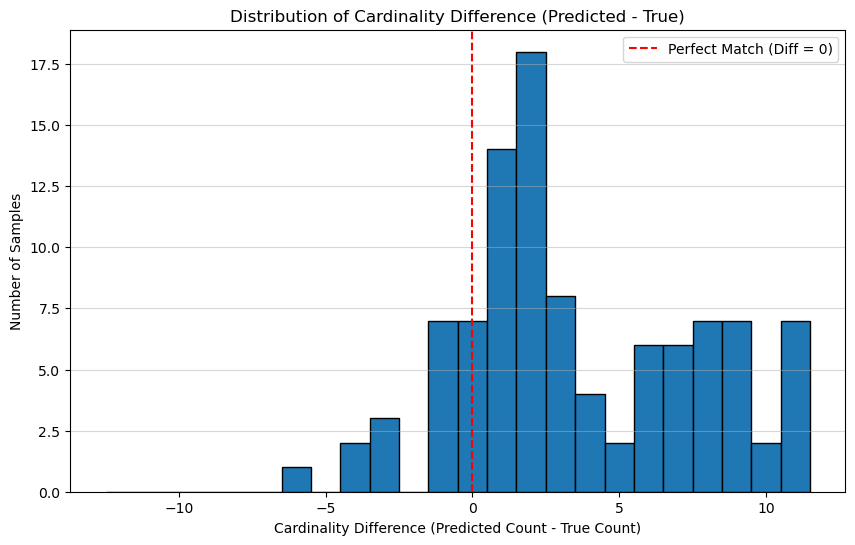

In [152]:
cardinality_true = np.sum(y_test_transformed, axis=1)
cardinality_pred = np.sum(y_pred_test_ovr, axis=1)
cardinality_difference = cardinality_pred - cardinality_true

max_abs_diff = np.abs(cardinality_difference).max()
bins = np.arange(-max_abs_diff, max_abs_diff + 1, 1)

plt.figure(figsize=(10, 6))
plt.hist(
    cardinality_difference,
    bins=bins,
    edgecolor='black',
    align='left' # Align bins so the zero bar is centered
)

# Add a vertical line at zero for reference
plt.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Perfect Match (Diff = 0)')

# Add title and labels
plt.title('Distribution of Cardinality Difference (Predicted - True)')
plt.xlabel('Cardinality Difference (Predicted Count - True Count)')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


We had a decent number of predictions that were close but many that predicted too many labels, as we suspected. We could adjust the positive threshold higher to be more in line with true cardinality.

Next we will create heatmaps for incorrect and correct predictions, by label and type.

In [153]:
cm_array = multilabel_confusion_matrix(y_test_transformed, y_pred_test_ovr)

df_heatmap = pd.DataFrame({
    'True Positives': cm_array[:, 1, 1],
    'False Negatives': cm_array[:, 1, 0],
    'False Positives': cm_array[:, 0, 1],
    'True Negatives': cm_array[:, 0, 0]
})

df_heatmap.index = y_test_transformed.columns.tolist()

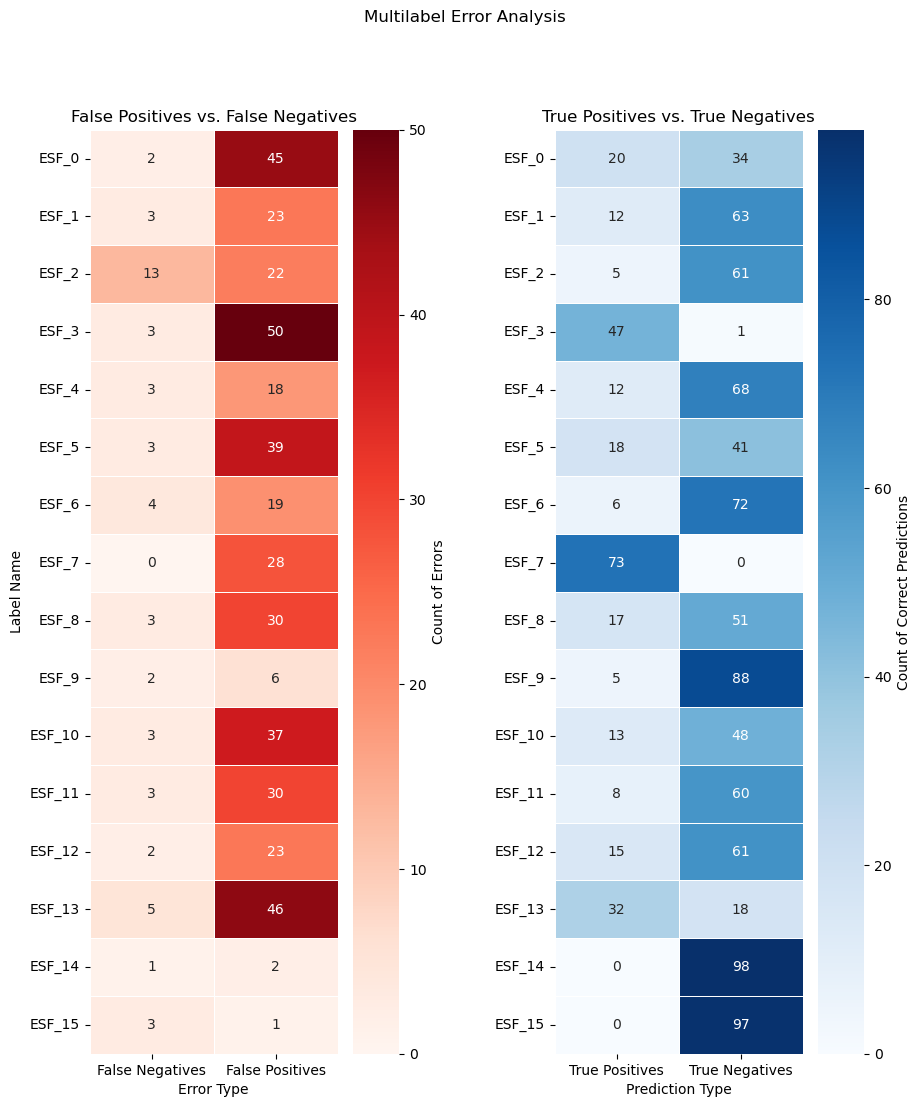

In [154]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(10, 12), 
)

ax_errors = axes[0]
df_errors = df_heatmap[['False Negatives', 'False Positives']]

sns.heatmap(
    df_errors,
    annot = True,
    fmt = 'd',
    cmap = 'Reds',
    linewidths = .5,
    cbar_kws = {'label': 'Count of Errors'},
    ax = ax_errors,
)

ax_errors.set_title('False Positives vs. False Negatives')
ax_errors.set_ylabel('Label Name')
ax_errors.set_xlabel('Error Type')
current_labels = ax_errors.get_yticklabels()
ax_errors.set_yticklabels(
    current_labels,
    rotation=0,
)

ax_correct = axes[1]
df_correct = df_heatmap[['True Positives', 'True Negatives']]

sns.heatmap(
    df_correct,
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    linewidths = .5,
    cbar_kws = {'label': 'Count of Correct Predictions'},
    ax = ax_correct
)

ax_correct.set_title('True Positives vs. True Negatives')
ax_correct.set_xlabel('Prediction Type')
ax_correct.set_yticklabels(
    current_labels,
    rotation=0,
)

fig.suptitle('Multilabel Error Analysis')
plt.subplots_adjust(wspace=0.5)
plt.show()

Our model did well by not predicting too many false negatives but did a bad job with false positives. This reflects the earlier plots that pointed to excessive ESF predictions when the true values were much lower.

We will perform a label co-occurence analysis to determine label correlation differences between the test set and our predictions.

In [279]:
# Generate a matrix of label combination counts for the test set
labels = y_test_transformed.columns.tolist()
label_len = len(labels)
true_corr = np.dot(y_test_transformed.T, y_test_transformed)
co_occurrence_df = pd.DataFrame(
    true_corr,
    index=labels,
    columns=labels,
)
co_occurrence_df

,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
ESF_0,22,11,11,16,7,11,4,19,9,5,12,8,9,11,1,0
ESF_1,11,15,12,15,9,10,5,15,11,6,14,10,12,11,1,3
ESF_2,11,12,18,14,9,9,6,14,13,7,12,9,12,12,1,2
ESF_3,16,15,14,50,13,17,8,33,15,7,16,11,16,23,1,3
ESF_4,7,9,9,13,15,8,5,10,10,6,10,9,11,9,0,3
ESF_5,11,10,9,17,8,21,7,20,10,6,12,7,10,15,1,2
ESF_6,4,5,6,8,5,7,10,10,7,4,6,5,7,9,0,2
ESF_7,19,15,14,33,10,20,10,73,13,7,16,11,14,32,1,3
ESF_8,9,11,13,15,10,10,7,13,20,7,12,9,13,11,1,3
ESF_9,5,6,7,7,6,6,4,7,7,7,7,5,7,7,1,2


In [280]:
# Get a normalized version of the co-occurrence counts
label_counts = np.diag(co_occurrence_df)
normalized_co_occurrence_df = co_occurrence_df.div(
    label_counts,
    axis=0,
    )
normalized_co_occurrence_df


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
ESF_0,1.000000,0.500000,0.500000,0.727273,0.318182,0.500000,0.181818,0.863636,0.409091,0.227273,0.545455,0.363636,0.409091,0.500000,0.045455,0.000000
ESF_1,0.733333,1.000000,0.800000,1.000000,0.600000,0.666667,0.333333,1.000000,0.733333,0.400000,0.933333,0.666667,0.800000,0.733333,0.066667,0.200000
ESF_2,0.611111,0.666667,1.000000,0.777778,0.500000,0.500000,0.333333,0.777778,0.722222,0.388889,0.666667,0.500000,0.666667,0.666667,0.055556,0.111111
ESF_3,0.320000,0.300000,0.280000,1.000000,0.260000,0.340000,0.160000,0.660000,0.300000,0.140000,0.320000,0.220000,0.320000,0.460000,0.020000,0.060000
ESF_4,0.466667,0.600000,0.600000,0.866667,1.000000,0.533333,0.333333,0.666667,0.666667,0.400000,0.666667,0.600000,0.733333,0.600000,0.000000,0.200000
ESF_5,0.523810,0.476190,0.428571,0.809524,0.380952,1.000000,0.333333,0.952381,0.476190,0.285714,0.571429,0.333333,0.476190,0.714286,0.047619,0.095238
ESF_6,0.400000,0.500000,0.600000,0.800000,0.500000,0.700000,1.000000,1.000000,0.700000,0.400000,0.600000,0.500000,0.700000,0.900000,0.000000,0.200000
ESF_7,0.260274,0.205479,0.191781,0.452055,0.136986,0.273973,0.136986,1.000000,0.178082,0.095890,0.219178,0.150685,0.191781,0.438356,0.013699,0.041096
ESF_8,0.450000,0.550000,0.650000,0.750000,0.500000,0.500000,0.350000,0.650000,1.000000,0.350000,0.600000,0.450000,0.650000,0.550000,0.050000,0.150000
ESF_9,0.714286,0.857143,1.000000,1.000000,0.857143,0.857143,0.571429,1.000000,1.000000,1.000000,1.000000,0.714286,1.000000,1.000000,0.142857,0.285714


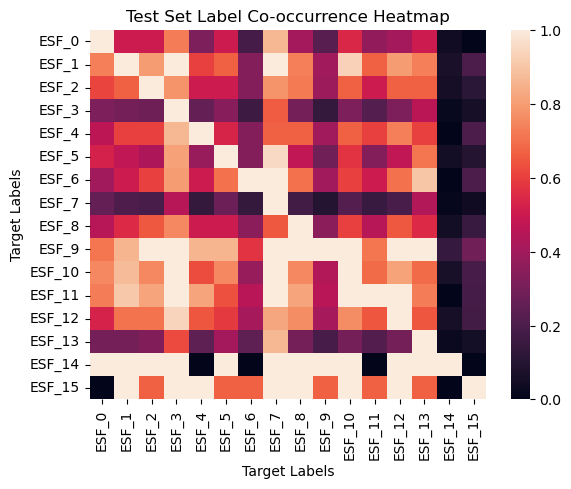

In [281]:
sns.heatmap(
    normalized_co_occurrence_df,
    annot=False,
    )
plt.title('Test Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

In [282]:
# Generate a matrix of label combination counts for the prediction set
pred_corr = np.dot(y_pred_test_ovr.T, y_pred_test_ovr)
pred_co_occurrence_df = pd.DataFrame(
    pred_corr,
    index=labels,
    columns=labels,
)

pred_co_occurrence_df


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
ESF_0,65,34,27,62,30,47,23,65,47,11,45,32,36,52,2,1
ESF_1,34,35,18,33,25,33,16,35,33,11,32,25,29,33,1,1
ESF_2,27,18,27,27,19,26,13,27,26,7,25,19,22,23,1,1
ESF_3,62,33,27,97,30,55,25,97,46,11,50,37,36,76,2,1
ESF_4,30,25,19,30,30,29,18,30,30,11,30,24,28,30,1,1
ESF_5,47,33,26,55,29,57,24,57,43,11,43,33,35,51,1,1
ESF_6,23,16,13,25,18,24,25,25,21,9,24,23,17,25,1,1
ESF_7,65,35,27,97,30,57,25,101,47,11,50,38,38,78,2,1
ESF_8,47,33,26,46,30,43,21,47,47,11,41,29,35,43,2,1
ESF_9,11,11,7,11,11,11,9,11,11,11,11,10,10,11,0,1


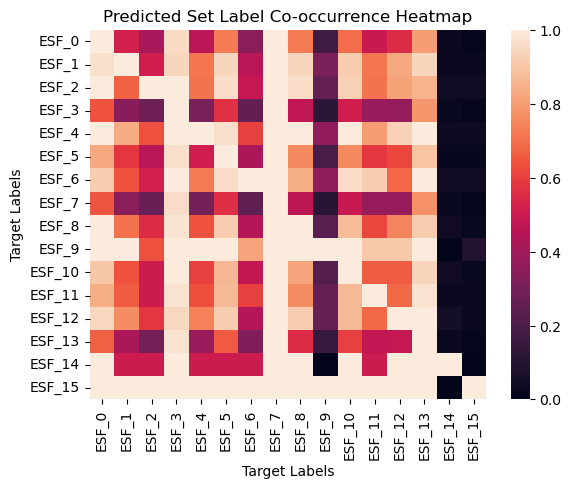

In [283]:
pred_label_counts = np.diag(pred_co_occurrence_df)
normalized_pred_co_occurrence_df = pred_co_occurrence_df.div(
    pred_label_counts,
    axis=0,
    )
sns.heatmap(
    normalized_pred_co_occurrence_df,
    annot=False,
    )
plt.title('Predicted Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

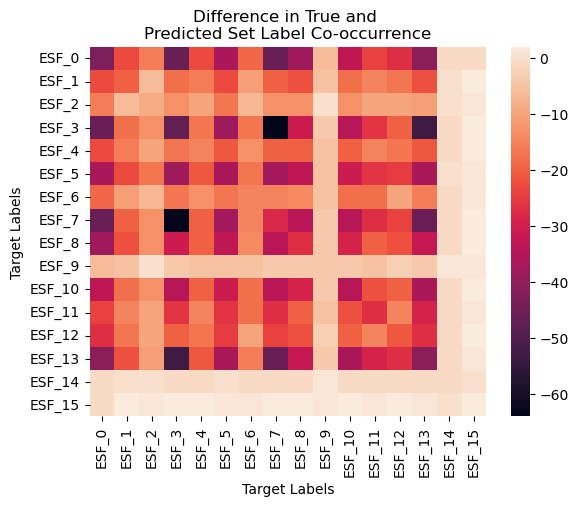

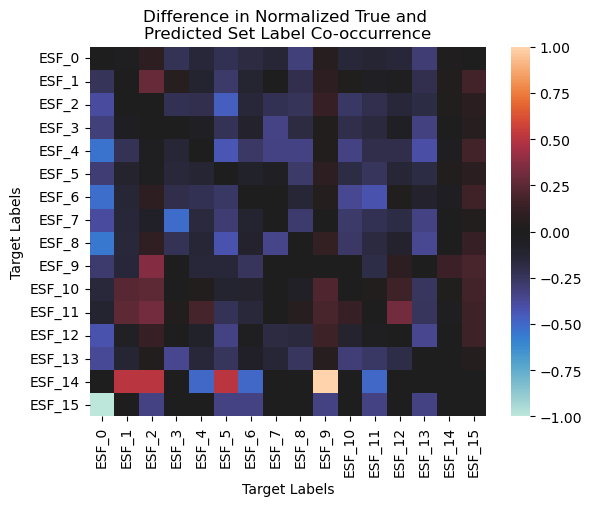

In [284]:
# Compare the differences between the test set and the prediction set

difference_df = co_occurrence_df - pred_co_occurrence_df
sns.heatmap(
    difference_df,
)
plt.title('Difference in True and \nPredicted Set Label Co-occurrence')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

norm_difference_df = normalized_co_occurrence_df - normalized_pred_co_occurrence_df
sns.heatmap(
    norm_difference_df,
    center=0
)
plt.title('Difference in Normalized True and \nPredicted Set Label Co-occurrence')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

There are definitely combinations of target labels that were underpredicted, with the worst being ESFs 9 and 14. There were other combinations with ESF 14 that also did poorly, both with underpredictions and overpredictions. It appears that ESF 15 and ESF 0 was not a real combination in the test set but is one that was predicted. Overall, our worst performance was on rare events, such as when ESFs 14 and 15 are present, and some of the more frequently occurring ESFs such as 0 and 13, though we did reasonably well when ESFs 3 or 7 were present.

We will now create a dataframe consisting of the label combinations and the error between the test set and the prediction set. Negative values will be overpredictions and positive values will be underpredictions.

In [285]:
difference_stack = (difference_df.stack().reset_index(name='difference').query('level_0 != level_1'))
largest_errors = difference_stack.reindex(difference_stack['difference'].abs().sort_values(ascending=False).index)
largest_errors.head(15)

,level_0,level_1,difference
115,ESF_7,ESF_3,-64
55,ESF_3,ESF_7,-64
61,ESF_3,ESF_13,-53
211,ESF_13,ESF_3,-53
112,ESF_7,ESF_0,-46
7,ESF_0,ESF_7,-46
48,ESF_3,ESF_0,-46
3,ESF_0,ESF_3,-46
125,ESF_7,ESF_13,-46
215,ESF_13,ESF_7,-46


We will also review combinations that worked well for the model by looking at the combinations in the tail.

In [286]:
largest_errors.tail(30)

,level_0,level_1,difference
242,ESF_15,ESF_2,1
237,ESF_14,ESF_13,-1
206,ESF_12,ESF_14,-1
191,ESF_11,ESF_15,1
190,ESF_11,ESF_14,-1
222,ESF_13,ESF_14,-1
234,ESF_14,ESF_10,-1
223,ESF_13,ESF_15,1
224,ESF_14,ESF_0,-1
227,ESF_14,ESF_3,-1


Many of our best and worst performances were on rare events, such as when ESFs 14 and/or 15 are present. We did manage to get all seven instances of ESFs 9 and 2 correct.

Let's compare it to the differences in the normalized sets.

In [287]:
normalized_difference_stack = (normalized_co_occurrence_df.stack().reset_index(name='difference').query('level_0 != level_1'))
normalized_largest_errors = normalized_difference_stack.reindex(normalized_difference_stack['difference'].abs().sort_values(ascending=False).index)
normalized_largest_errors.head(15)

,level_0,level_1,difference
23,ESF_1,ESF_7,1.0
19,ESF_1,ESF_3,1.0
103,ESF_6,ESF_7,1.0
247,ESF_15,ESF_7,1.0
167,ESF_10,ESF_7,1.0
179,ESF_11,ESF_3,1.0
186,ESF_11,ESF_10,1.0
183,ESF_11,ESF_7,1.0
154,ESF_9,ESF_10,1.0
156,ESF_9,ESF_12,1.0


In [288]:
normalized_largest_errors.tail(15)

,level_0,level_1,difference
14,ESF_0,ESF_14,0.045455
127,ESF_7,ESF_15,0.041096
222,ESF_13,ESF_14,0.027027
62,ESF_3,ESF_14,0.020000
126,ESF_7,ESF_14,0.013699
15,ESF_0,ESF_15,0.000000
78,ESF_4,ESF_14,0.000000
110,ESF_6,ESF_14,0.000000
190,ESF_11,ESF_14,0.000000
228,ESF_14,ESF_4,0.000000


Next we will look at permutation importance across the feature groups.

In [289]:

groups = {
    'state': state_columns,
    'region': region_columns,
    'declarationType': declaration_columns,
    'designatedIncidentTypes': type_columns
}

def grouped_feature_permutation(
    model,
    X,
    y,
    groups,
    metric_,
):
    baseline = combined_score(y_true=y, y_pred=model.predict(X = X))
    group_importance = {}
    group_importance['baseline'] = baseline
    for group, columns in groups.items():
        score_changes = []
        rng = np.random.default_rng(seed = random_state)
        for i in range(1,11):
            X_perm = X.copy()
            shuffled_ind = rng.permutation(X.index)
            X_perm[columns] = X_perm[columns].values[shuffled_ind]
            perm_score = combined_score(y_true= y, y_pred=model.predict(X_perm),)
            score_changes.append(perm_score)
        group_importance[group] = (f'Mean: {np.mean(score_changes)}', #Mean
                                   f'Max: {np.max(score_changes)}', #Max
                                   f'Min: {np.min(score_changes)}', #Min
                                   f'Std: {np.std(score_changes)}') #Std
    labels = []
    means = []
    errors = []

    for key, value in group_importance.items():
        if key == "baseline":
            y_line = (value)
        else:
            mean_val = float(value[0].split(":")[1])
            std_val = float(value[3].split(":")[1])
            labels.append(key)
            means.append(mean_val)
            errors.append(std_val)
    # Create a plot of values
    plt.figure(figsize=(10,6))
    plt.bar(labels,
            means,
            yerr=errors)
    plt.axhline(y=y_line,
                color='k',
                linestyle='--',
                label='Baseline',
                )
    plt.ylim([0, 1.5])
    plt.ylabel('Combined Metric Score')
    plt.title('Performance Given Permuted Values of Feature Groups')
    plt.tight_layout()
    plt.show()

    return group_importance

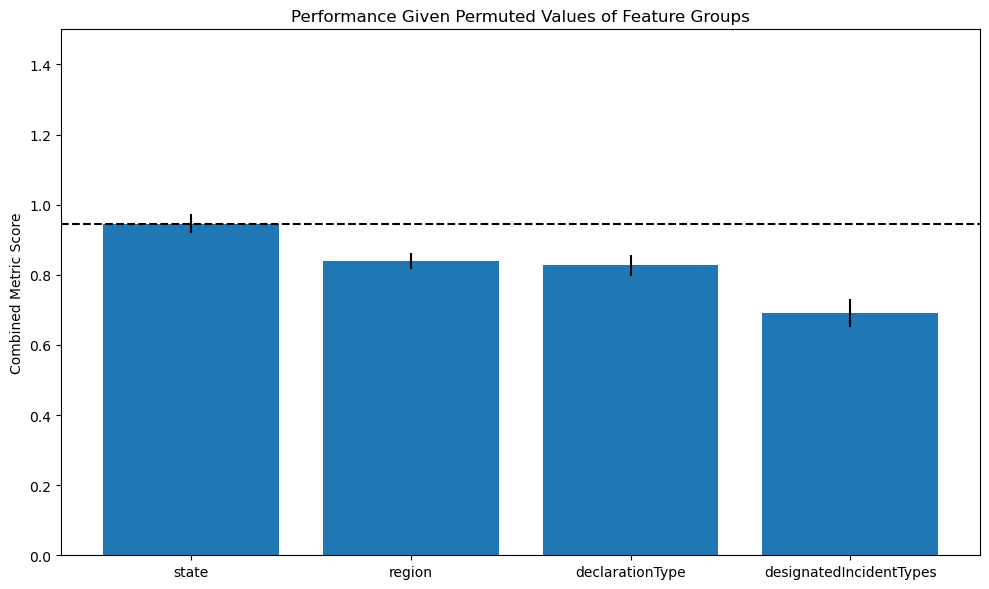

{'baseline': 0.9451766722796282,
 'state': ('Mean: 0.9455843678356203',
  'Max: 1.0027728733999237',
  'Min: 0.9045203251401869',
  'Std: 0.02673749150572683'),
 'region': ('Mean: 0.8403739280188116',
  'Max: 0.876358335560685',
  'Min: 0.8084996951379047',
  'Std: 0.023012736918408203'),
 'declarationType': ('Mean: 0.8273394332825195',
  'Max: 0.8864181305371424',
  'Min: 0.7917090861422991',
  'Std: 0.02960597818362227'),
 'designatedIncidentTypes': ('Mean: 0.690404991839094',
  'Max: 0.7579044401705579',
  'Min: 0.629227987310503',
  'Std: 0.04025537883521794')}

In [290]:
perm_scores = grouped_feature_permutation(study_ovrxgb_tuned,
                                          X_test_transformed,
                                          y_test_transformed,
                                          groups,
                                          F1_Macro_Avg)

perm_scores

Permutations of state actually seem to have improved the results over the baseline, whereas every other group results in lower scores. Changing the designatedIncidentTypes has the biggest negative impact on the final metric score compared to the baseline.

Let us start analyzing edge cases. We can begin by picking a few rows from the same incident and comparing outcomes for different states.

In [291]:
X_test['incidentId'].value_counts()

incidentId
2012102505    13
2021082601     8
2020091301     6
2021081902     3
2023081703     3
2018031201     2
2020041101     2
2021081801     2
2020010701     2
2022122101     2
2023030901     2
2024042701     2
2024052402     2
2024080901     2
2013051001     1
2013050601     1
2016092301     1
2016100501     1
2017012001     1
2016100502     1
2013062801     1
2013070101     1
2013070102     1
2013060301     1
2014061802     1
2014071703     1
2015021101     1
2015050801     1
2016012701     1
2016061101     1
2016081301     1
2014020501     1
2019110801     1
2019110101     1
2019101801     1
2018082801     1
2018041602     1
2018022302     1
2017110602     1
2017110601     1
2017021001     1
2017072901     1
2017052601     1
2017031101     1
2021080901     1
2021062401     1
2020082004     1
2020020701     1
2022081903     1
2022070501     1
2022062801     1
2022051202     1
2022010701     1
2022010301     1
2023081101     1
2023030102     1
2023090401     1
2023082901     1
202

In [292]:
X_test[X_test['incidentId']==2012102505]

,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2012102505,CT,[Hurricane],DR,1,2012.0
1,2012102505,DC,[Hurricane],EM,3,2012.0
2,2012102505,DE,[Hurricane],DR,3,2012.0
3,2012102505,DE,[Hurricane],EM,3,2012.0
4,2012102505,MD,[Hurricane],DR,3,2012.0
5,2012102505,MD,[Hurricane],EM,3,2012.0
6,2012102505,NJ,[Hurricane],DR,2,2012.0
7,2012102505,NY,[Hurricane],DR,2,2012.0
8,2012102505,PA,[Hurricane],EM,3,2012.0
9,2012102505,RI,[Hurricane],DR,1,2012.0


In [293]:
print(X_test.iloc[8], y_test_transformed.iloc[8], y_pred_test_ovr[8])

incidentId                  2012102505
state                               PA
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
year                            2012.0
Name: 8, dtype: object ESF_0     0
ESF_1     0
ESF_2     0
ESF_3     1
ESF_4     1
ESF_5     0
ESF_6     0
ESF_7     0
ESF_8     1
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 8, dtype: int64 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]


In [294]:
print(X_test.iloc[1], y_test_transformed.iloc[1], y_pred_test_ovr[1])


incidentId                  2012102505
state                               DC
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
year                            2012.0
Name: 1, dtype: object ESF_0     0
ESF_1     0
ESF_2     0
ESF_3     0
ESF_4     1
ESF_5     0
ESF_6     0
ESF_7     0
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 1, dtype: int64 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]


In [295]:
print(X_test.iloc[5], y_test_transformed.iloc[5], y_pred_test_ovr[5])


incidentId                  2012102505
state                               MD
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
year                            2012.0
Name: 5, dtype: object ESF_0     0
ESF_1     0
ESF_2     0
ESF_3     0
ESF_4     1
ESF_5     0
ESF_6     0
ESF_7     0
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 5, dtype: int64 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]


In [296]:
print(X_test.iloc[0], y_test_transformed.iloc[0], y_pred_test_ovr[0])


incidentId                  2012102505
state                               CT
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               1
year                            2012.0
Name: 0, dtype: object ESF_0     0
ESF_1     1
ESF_2     0
ESF_3     1
ESF_4     1
ESF_5     0
ESF_6     0
ESF_7     1
ESF_8     1
ESF_9     0
ESF_10    1
ESF_11    1
ESF_12    1
ESF_13    0
ESF_14    0
ESF_15    1
Name: 0, dtype: int64 [0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0]


In [297]:
print(X_test.iloc[10], y_test_transformed.iloc[10], y_pred_test_ovr[10])


incidentId                  2012102505
state                               VA
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               3
year                            2012.0
Name: 10, dtype: object ESF_0     0
ESF_1     0
ESF_2     0
ESF_3     0
ESF_4     0
ESF_5     0
ESF_6     0
ESF_7     1
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 10, dtype: int64 [1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0]


Here we see five match incidentId values with matching designatedIncidentTypes across five different states with varying declarationTypes. This helps show some of the difficulties in predicting ESFs based on very few features. The disaster in Connecticut varies from the disaster in Virginia only by state, but the incident in Connecticut required nine different ESFs while in Virginia is only required one. It is interesting that the event in Connecticut did not result in nearly as many positive predicted labels as the incident in Virgina. Had those been flipped, our outcomes would have improved in both locations.

Lets look at some of the incidents in the test set with large label sets to see how we performed in those cases.

In [298]:
label_set_counts_true = y_test_transformed.sum(axis=1)
edge_cases_large_label_sets = label_set_counts_true.sort_values()
edge_cases_large_label_sets[-10:]

26    10
46    12
89    12
6     13
50    13
81    13
63    13
65    13
64    13
7     14
dtype: int64

In [299]:
print(X_test.iloc[7], y_test_transformed.iloc[7], y_pred_test_ovr[7])


incidentId                  2012102505
state                               NY
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               2
year                            2012.0
Name: 7, dtype: object ESF_0     0
ESF_1     1
ESF_2     1
ESF_3     1
ESF_4     1
ESF_5     1
ESF_6     1
ESF_7     1
ESF_8     1
ESF_9     1
ESF_10    1
ESF_11    1
ESF_12    1
ESF_13    1
ESF_14    0
ESF_15    1
Name: 7, dtype: int64 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]


In [300]:
print(X_test.iloc[64], y_test_transformed.iloc[64], y_pred_test_ovr[64])


incidentId                  2021082601
state                               LA
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               6
year                            2021.0
Name: 64, dtype: object ESF_0     1
ESF_1     0
ESF_2     1
ESF_3     1
ESF_4     1
ESF_5     1
ESF_6     1
ESF_7     1
ESF_8     1
ESF_9     1
ESF_10    1
ESF_11    1
ESF_12    1
ESF_13    1
ESF_14    0
ESF_15    0
Name: 64, dtype: int64 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]


In [301]:
print(X_test.iloc[81], y_test_transformed.iloc[81], y_pred_test_ovr[81])


incidentId                                                      2023030901
state                                                                   CA
designatedIncidentTypes    [Flood, Snowstorm, Severe Storm, Mud/Landslide]
declarationType                                                         EM
region                                                                   9
year                                                                2023.0
Name: 81, dtype: object ESF_0     1
ESF_1     1
ESF_2     1
ESF_3     1
ESF_4     1
ESF_5     1
ESF_6     0
ESF_7     1
ESF_8     1
ESF_9     1
ESF_10    1
ESF_11    1
ESF_12    1
ESF_13    1
ESF_14    0
ESF_15    0
Name: 81, dtype: int64 [1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0]


In [302]:
print(X_test.iloc[50], y_test_transformed.iloc[50], y_pred_test_ovr[50])


incidentId                 2020082004
state                              CA
designatedIncidentTypes        [Fire]
declarationType                    DR
region                              9
year                           2020.0
Name: 50, dtype: object ESF_0     1
ESF_1     1
ESF_2     1
ESF_3     1
ESF_4     1
ESF_5     1
ESF_6     1
ESF_7     1
ESF_8     1
ESF_9     0
ESF_10    1
ESF_11    1
ESF_12    1
ESF_13    1
ESF_14    0
ESF_15    0
Name: 50, dtype: int64 [1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0]


In [303]:
print(X_test.iloc[26], y_test_transformed.iloc[26], y_pred_test_ovr[26])


incidentId                 2016081301
state                              LA
designatedIncidentTypes       [Flood]
declarationType                    DR
region                              6
year                           2016.0
Name: 26, dtype: object ESF_0     0
ESF_1     1
ESF_2     0
ESF_3     1
ESF_4     0
ESF_5     1
ESF_6     1
ESF_7     1
ESF_8     1
ESF_9     0
ESF_10    1
ESF_11    1
ESF_12    1
ESF_13    1
ESF_14    0
ESF_15    0
Name: 26, dtype: int64 [1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0]


We did fairly well on the large datasets. Let's look for instances with the worst differences in cardinality.

In [304]:
label_set_counts_pred = y_pred_test_ovr.sum(axis=1)
label_set_counts_true-label_set_counts_pred


0       4
1     -11
2     -11
3     -11
4     -11
5     -11
6      -1
7       0
8      -9
9      -4
10     -9
11    -10
12     -7
13     -6
14     -2
15     -3
16     -2
17     -3
18     -3
19     -7
20     -3
21     -8
22     -2
23     -2
24      1
25     -2
26      3
27     -6
28     -1
29     -1
30     -2
31     -1
32     -2
33     -1
34     -1
35     -1
36     -4
37      0
38      0
39     -1
40     -8
41      0
42     -8
43     -1
44     -2
45      3
46      3
47     -2
48      1
49     -1
50      1
51     -3
52     -6
53     -8
54    -12
55     -6
56     -5
57     -8
58     -9
59     -4
60     -3
61     -5
62     -9
63      6
64     -1
65      1
66     -4
67     -9
68     -7
69     -9
70     -8
71    -10
72     -1
73     -1
74      0
75     -2
76     -2
77     -3
78     -2
79     -2
80     -6
81      0
82     -9
83     -2
84     -6
85     -8
86     -7
87     -2
88    -12
89      4
90      1
91      1
92     -2
93      0
94      1
95     -1
96     -3
97     -7
98     -7
99     -2


He is one from the large label set series above that we did not check. 

In [305]:
print(X_test.iloc[63], y_test_transformed.iloc[63], y_pred_test_ovr[63])


incidentId                  2021081902
state                               RI
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               1
year                            2021.0
Name: 63, dtype: object ESF_0     1
ESF_1     1
ESF_2     1
ESF_3     1
ESF_4     1
ESF_5     1
ESF_6     0
ESF_7     1
ESF_8     1
ESF_9     1
ESF_10    1
ESF_11    1
ESF_12    1
ESF_13    1
ESF_14    0
ESF_15    0
Name: 63, dtype: int64 [1 1 0 0 0 1 0 1 1 0 0 0 1 1 0 0]


Interesting. It is a hurricane like many of the above but the state is Rhode Island. That made the model underpredict the necessary ESFs.

Now we can look at some of the worst overpredictions.

In [306]:
print(X_test.iloc[54], y_test_transformed.iloc[54], y_pred_test_ovr[54])


incidentId                  2020091301
state                               FL
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               4
year                            2020.0
Name: 54, dtype: object ESF_0     1
ESF_1     0
ESF_2     0
ESF_3     0
ESF_4     0
ESF_5     1
ESF_6     0
ESF_7     1
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 54, dtype: int64 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


In [307]:
print(X_test.iloc[88], y_test_transformed.iloc[88], y_pred_test_ovr[88])


incidentId                    2023082901
state                                 WA
designatedIncidentTypes    [Other, Fire]
declarationType                       DR
region                                10
year                              2023.0
Name: 88, dtype: object ESF_0     0
ESF_1     0
ESF_2     0
ESF_3     0
ESF_4     0
ESF_5     0
ESF_6     0
ESF_7     1
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    1
ESF_14    0
ESF_15    0
Name: 88, dtype: int64 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0]


Here we see a hurrican and a fire that generated very few ESFs in reality but our model predicts the need for many more.

We will round out our error analysis by checking predictions with the worst Jaccard similarity scores.

In [308]:
# Find predictions with the lowest Jaccard similarity between the test set and the prediction set.

jaccard_series = pd.Series(
    [
        jaccard_score(y_test_transformed.iloc[i], y_pred_test_ovr[i], average='macro')
        for i in range(len(y_test_transformed))
    ],
    index=y_test_transformed.index
)
jaccard_series.sort_values()


54     0.138462
88     0.142857
3      0.175000
1      0.175000
5      0.175000
4      0.175000
2      0.175000
11     0.212121
85     0.212121
71     0.226190
62     0.250000
10     0.250000
86     0.250000
58     0.269481
67     0.269481
82     0.269481
69     0.269481
8      0.278846
56     0.281250
84     0.288889
40     0.288889
42     0.314286
53     0.314286
70     0.314286
57     0.328671
55     0.328671
0      0.328671
97     0.329167
98     0.329167
21     0.333333
25     0.371429
13     0.371429
9      0.371429
27     0.371429
12     0.380769
19     0.380769
68     0.380769
35     0.406250
52     0.410714
80     0.410714
63     0.435897
59     0.435897
61     0.464286
23     0.466667
36     0.466667
91     0.495192
26     0.522727
66     0.523810
95     0.525000
20     0.525000
15     0.525000
18     0.525000
17     0.525000
6      0.525000
96     0.525000
77     0.525000
73     0.525000
89     0.583333
65     0.592857
47     0.600000
7      0.600000
38     0.600000
32     0

In [309]:
print(X_test.iloc[3], y_test_transformed.iloc[3], y_pred_test_ovr[3])


incidentId                  2012102505
state                               DE
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
year                            2012.0
Name: 3, dtype: object ESF_0     0
ESF_1     0
ESF_2     1
ESF_3     0
ESF_4     0
ESF_5     0
ESF_6     0
ESF_7     0
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 3, dtype: int64 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]


In [310]:
print(X_test.iloc[11], y_test_transformed.iloc[11], y_pred_test_ovr[11])


incidentId                  2012102505
state                               WV
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               3
year                            2012.0
Name: 11, dtype: object ESF_0     0
ESF_1     0
ESF_2     0
ESF_3     0
ESF_4     0
ESF_5     0
ESF_6     0
ESF_7     1
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 11, dtype: int64 [1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0]


The first two are from the same incidentId as we checked before. Again, changing the state and declaration type results in substantial changes to the ESFs required for this designatedIncidentType and our model falsely predicts the need for many ESFs.

In [311]:
print(X_test.iloc[85], y_test_transformed.iloc[85], y_pred_test_ovr[85])


incidentId                                             2023081703
state                                                          CA
designatedIncidentTypes    [Flood, Mud/Landslide, Tropical Storm]
declarationType                                                DR
region                                                          9
year                                                       2023.0
Name: 85, dtype: object ESF_0     0
ESF_1     0
ESF_2     1
ESF_3     0
ESF_4     0
ESF_5     0
ESF_6     0
ESF_7     0
ESF_8     1
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 85, dtype: int64 [1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0]


In [312]:
print(X_test.iloc[71], y_test_transformed.iloc[71], y_pred_test_ovr[71])


incidentId                  2021082601
state                               PA
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               3
year                            2021.0
Name: 71, dtype: object ESF_0     0
ESF_1     0
ESF_2     0
ESF_3     0
ESF_4     0
ESF_5     0
ESF_6     0
ESF_7     1
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    1
ESF_14    0
ESF_15    0
Name: 71, dtype: int64 [1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0]


These last two again have designatedIncidentTypes that would signify need for significant support according to the model but in reality did not require many Emergency Support Functions at all. There appears to be a feature missing that would indicate severity of the incident in a more nuanced way than declarationType provides. 